In [86]:
!pip install pgeocode
!pip install pingouin
!conda install -c pyviz hvplot -y
!conda install -y --channel conda-forge geopandas
!conda install -c conda-forge fiona -y



Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [87]:
import os


os.environ["DASK_TEMPORARY_DIRECTORY"] = "tmp/dask"
os.environ["PGEOCODE_DATA_DIR"] = "tmp/pgeocode_data"
if not os.path.exists("tmp"):
    os.mkdir("tmp")
if not os.path.exists("tmp/dask"):
    os.mkdir("tmp/dask")
if not os.path.exists("tmp/pgeocode_data"):
    os.mkdir("tmp/pgeocode_data")
import pandas as pd
import hvplot.pandas
import dask
import hvplot.dask
import dask.dataframe as dd
import json
import tqdm
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import pgeocode as geo
import geopandas as gpd
import fiona
import panel as pn
pn.extension(comms="vscode")
from scipy.stats import entropy


In [88]:
!ls data_dpg_testdata/reduced/ 

mapping_article_files.json
mapping_city.json
mapping_geo.json
mapping_refferer.json
mapping_view_files.json
reduced_articles_df_article.csv
reduced_articles_df_external_categories.csv
reduced_articles_df_external_entities.csv
reduced_articles_df_external_topics.csv
reduced_articles_df_fixed_set_sensitive.csv
reduced_articles_df_fixed_set_topics.csv
reduced_articles_df_fixed_set_userneeds.csv
reduced_articles_df_internal_topics.csv
reduced_interactions.csv
reduced_views.csv


In [89]:
DATA_FOLDER = "reduced"

In [90]:
ddf_views = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER}/reduced_views.csv', dtype={
       'GEO_ZIPCODE': object,
       'REFR_MEDIUM': object, 'IS_LOGGED_IN': object, 'file_name': object,
       "privacy_advertising":int,       
       "privacy_analytics":int,       
       "privacy_functional":int,       
       "privacy_geo_location":int,       
       "privacy_marketing":int,       
       "privacy_non-personalised_ads":int,       
       "privacy_personalisation":int,       
       "privacy_social_media":int,       
       "privacy_target_advertising":int,       
       'ARTICLE_ID':"str",
       })
ddf_views["article_id"] = ddf_views["ARTICLE_ID"]
# ddf_views = ddf_views.drop(["ARTICLE_ID"] , axis=1)
ddf_views["DERIVED_TSTAMP"] = dd.to_datetime(ddf_views["DERIVED_TSTAMP"])
ddf_views["dt_hour"] = ddf_views["DERIVED_TSTAMP"].dt.hour
ddf_views["dt_weekday"] = ddf_views["DERIVED_TSTAMP"].dt.weekday
ddf_views["dt_dayofmonth"] = ddf_views["DERIVED_TSTAMP"].dt.day
ddf_views["dt_month"] = ddf_views["DERIVED_TSTAMP"].dt.month
ddf_views = ddf_views.replace("nu.web.advertorial", "nu.web")
ddf_views_unidentified = ddf_views[ddf_views["QUASI_USER_ID"].isna()].copy()
ddf_views = ddf_views[~ddf_views["QUASI_USER_ID"].isna()]
device_counts = ddf_views["APP_ID"].value_counts().compute()
# sample_amount = (device_counts.min()//100000)*100000
sample_amount = device_counts.min()
# sample_amount = 1000000
unique_devices = device_counts.index.unique()
columns_privacy = list(ddf_views.columns[ddf_views.columns.str.startswith("privacy_")].values)
columns_time = ["hour", "weekday", "dayofmonth", "month"]
ddf_views = ddf_views.groupby('APP_ID').apply(lambda df: df.sample(sample_amount if len(df) else 0) , meta=ddf_views.partitions[0]).reset_index(drop=True)
ddf_views = ddf_views.set_index('article_id')
ddf_views

Dask DataFrame Structure:
                APP_ID ARTICLE_ID  DERIVED_TSTAMP GEO_CITY GEO_COUNTRY GEO_REGION GEO_ZIPCODE REFR_MEDIUM REFR_URLHOST QUASI_USER_ID IS_LOGGED_IN privacy_functional privacy_analytics privacy_target_advertising privacy_personalisation privacy_non-personalised_ads privacy_marketing privacy_social_media privacy_geo_location privacy_advertising file_name dt_hour dt_weekday dt_dayofmonth dt_month
npartitions=12                                                                                                                                                                                                                                                                                                                                                                                            
1005304         object     object  datetime64[ns]    int64      object     object      object      object        int64        object       object              int64             int64                      int64                   int64                        int64             int64                int64                int64               int64    object   int64      int64         int64    int64
6191089            ...        ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...     ...        ...           ...      ...
...                ...        ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...     ...        ...           ...      ...
6192810            ...        ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...     ...        ...           ...      ...
TNwse80V           ...        ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...     ...        ...           ...      ...
Dask Name: sort_index, 36 graph layers

In [91]:
DATA_FOLDER_ARTICLES = "reduced"
ddf_article = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_article.csv', dtype={'sub_section': 'object', 'url': 'object'})
ddf_article = ddf_article.set_index('article_id')
ddf_article.index = ddf_article.index.astype('str')
ddf_article.head()

cds_content_id brands  \
article_id                                               
537071      article-mm-6229c19da07c8a000163379b  nu.nl   
962788      article-mm-621539e134c4a7000191db08  nu.nl   
1013291     article-mm-6239e222e28ee500012c67ff  nu.nl   
1149251     article-mm-6229c559c1fdac00016a6b3e  nu.nl   
1401797     article-mm-626a799867ff2a00019c059e  nu.nl   

                                               title  \
article_id                                             
537071       Peugeot 307 in alle opzichten verbeterd   
962788         Hier is hij dan: de nieuwe Volvo V70!   
1013291                           De Peugeot 207 SW!   
1149251               Meer details nieuwe Opel Agila   
1401797     Oranje meest populair voor Dodge Charger   

                                                         text      authors  \
article_id                                                                   
537071      Het nieuwe gezicht komt op alle carrosserievar...          ANP   
962788      De voorzijde van de Volvo V70 krijgt trekken v...  autoweek.nl   
1013291     In de Peugeot-vestiging in Poissy is de voorse...  autoweek.nl   
1149251     De beelden die we eerder al liet zien toonden ...  autoweek.nl   
1401797     Dodge heeft onlangs de Charger nieuw leven ing...  autoweek.nl   

                                                          url main_section  \
article_id                                                                   
537071      https://nu.nl/auto/537071/peugeot-307-in-alle-...     Economie   
962788      https://nu.nl/auto/962788/hier-is-hij-dan-de-n...     Onderweg   
1013291     https://nu.nl/auto/1013291/de-peugeot-207-sw.html     Onderweg   
1149251     https://nu.nl/auto/1149251/meer-details-nieuwe...     Onderweg   
1401797     https://nu.nl/auto/1401797/oranje-meest-popula...     Economie   

           sub_section  num_words  num_sentences  num_chars  \
article_id                                                    
537071        Onderweg        351             27       2327   
962788             NaN          0              0          0   
1013291            NaN        170             17       1081   
1149251            NaN        361             27       2134   
1401797       Onderweg        178             20       1133   

            first_publication_timestamp categories_generated keywords_curated  \
article_id                                                                      
537071                              NaN             Onderweg              NaN   
962788                              NaN             Onderweg              NaN   
1013291                             NaN             Onderweg              NaN   
1149251                             NaN             Onderweg              NaN   
1401797                             NaN             Onderweg              NaN   

            brand_safety_is_brandsafe  brand_safety_confidence  file_name  
article_id                                                                 
537071                           True                      0.1          3  
962788                           True                      0.1          1  
1013291                          True                      0.1          2  
1149251                          True                      0.1          3  
1401797                          True                      0.1          3

In [107]:
ddf_topics = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_topics.csv', dtype={"article_id":"str"})
topic_columns = ddf_topics.columns[ddf_topics.columns.str.startswith("topic_")].values
ddf_topics = ddf_topics.reset_index().set_index('index')
ddf_topics = ddf_topics.assign(article_topic_entropy = dd.from_array(entropy(ddf_topics[topic_columns], axis=1)))
ddf_topics = ddf_topics.assign(argmax_topic = dd.from_array(ddf_topics[topic_columns].idxmax(axis=1).compute().values))
ddf_topics = ddf_topics.set_index('article_id')
ddf_topics.head()

topic_voetbal  topic_optredens_en_voorstellingen  topic_politiek  \
article_id                                                                     
1013291          0.105175                           0.028085        0.001613   
1149251          0.096021                           0.001019        0.000872   
1401797          0.002146                           0.001896        0.001623   
1420717          0.001877                           0.032115        0.001420   
1505884          0.002216                           0.001958        0.023487   

            topic_technologie_en_handel  topic_relatie_en_opvoeden  \
article_id                                                           
1013291                        0.025450                   0.024846   
1149251                        0.021542                   0.002109   
1401797                        0.002359                   0.004391   
1420717                        0.044774                   0.003638   
1505884                        0.002437                   0.004154   

            topic_bestuur_en_organisatie  topic_human_interest  \
article_id                                                       
1013291                         0.001953              0.036237   
1149251                         0.001056              0.011584   
1401797                         0.001965              0.002967   
1420717                         0.063106              0.002595   
1505884                         0.002029              0.003056   

            topic_verkeersongevallen  topic_nominatie_en_prijzen  \
article_id                                                         
1013291                     0.063389                    0.041297   
1149251                     0.148419                    0.000740   
1401797                     0.001080                    0.022382   
1420717                     0.068904                    0.001204   
1505884                     0.093302                    0.057185   

            topic_veiligheid  ...  topic_overheidsbeleid  \
article_id                    ...                          
1013291             0.001265  ...               0.024950   
1149251             0.000684  ...               0.001159   
1401797             0.001273  ...               0.002157   
1420717             0.001114  ...               0.001887   
1505884             0.016235  ...               0.002224   

            topic_vakbond_club_en_vereniging  topic_religie  \
article_id                                                    
1013291                             0.049110       0.001384   
1149251                             0.014120       0.000748   
1401797                             0.019468       0.001393   
1420717                             0.155525       0.001218   
1505884                             0.020908       0.001437   

            topic_bouwen_en_wonen  topic_recht_en_justitie  topic_samenleving  \
article_id                                                                      
1013291                  0.001251                 0.001558           0.001142   
1149251                  0.000677                 0.000842           0.000617   
1401797                  0.001259                 0.001567           0.001149   
1420717                  0.001101                 0.001371           0.001005   
1505884                  0.065164                 0.001618           0.001186   

            topic_woon_en_leefomgeving  file_name  article_topic_entropy  \
article_id                                                                 
1013291                       0.054470          2               2.660889   
1149251                       0.039665          3               2.116882   
1401797                       0.003774          3               2.471787   
1420717                       0.022787          3               2.527454   
1505884                       0.051443          3               2.486128   

                                argmax_topic  
article_i

In [122]:
ddf_userneeds = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_userneeds.csv', dtype={'article_id':'str'})
columns_userneeds = ddf_userneeds.columns[ddf_userneeds.columns.str.startswith("userneed_")].values
ddf_userneeds = ddf_userneeds.assign(argmax_userneeds = ddf_userneeds[columns_userneeds].idxmax(axis=1))
ddf_userneeds = ddf_userneeds.set_index('article_id')
ddf_userneeds.head()

userneed_hou_me_op_de_hoogte  userneed_geef_me_context  \
article_id                                                           
1013291                         0.132751                  0.059254   
1149251                         0.159672                  0.108233   
1401797                         0.071099                  0.054092   
1420717                         0.393687                  0.159692   
1505884                         0.149060                  0.400487   

            userneed_vermaak_me  userneed_raak_me_verbind_me  \
article_id                                                     
1013291                0.704135                     0.089935   
1149251                0.444364                     0.015201   
1401797                0.790514                     0.059013   
1420717                0.321118                     0.030522   
1505884                0.137633                     0.304317   

            userneed_help_me  file_name              argmax_userneeds  
article_id                                                             
1013291             0.013925          2           userneed_vermaak_me  
1149251             0.272529          3           userneed_vermaak_me  
1401797             0.025282          3           userneed_vermaak_me  
1420717             0.094981          3  userneed_hou_me_op_de_hoogte  
1505884             0.008503          3      userneed_geef_me_context

In [123]:
ddf_sensitivity = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_sensitive.csv', dtype={'article_id':'str'})
columns_sensitivity = list(ddf_sensitivity.columns[ddf_sensitivity.columns.str.startswith("sensitive_")].values)
ddf_sensitivity = ddf_sensitivity.assign(argmax_sensitivity = ddf_sensitivity[columns_sensitivity].idxmax(axis=1))
ddf_sensitivity = ddf_sensitivity.assign(is_sensitive = ddf_sensitivity[columns_sensitivity].sum(axis=1))
ddf_sensitivity = ddf_sensitivity.dropna(subset="sensitive_topic_terrorism")
ddf_sensitivity = ddf_sensitivity.assign(article_sensitivity_entropy = ddf_sensitivity[columns_sensitivity].apply(lambda x: entropy(x) if x.sum()!=0 else 0, axis=1, meta='float64'))
ddf_sensitivity = ddf_sensitivity.set_index('article_id')
# ddf_sensitivity = ddf_sensitivity.persist()
ddf_sensitivity.head()

/home/bestname/anaconda3/envs/dpg/lib/python3.10/site-packages/dask/dataframe/core.py:6751: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


sensitive_topic_adult  sensitive_topic_arms  \
article_id                                                
1013291                       0.0                   0.0   
1149251                       0.0                   0.0   
1401797                       0.0                   0.0   
1420717                       0.0                   0.0   
1505884                       0.0                   0.0   

            sensitive_topic_crime  sensitive_topic_death  \
article_id                                                 
1013291                       0.0               0.000000   
1149251                       0.0               0.000000   
1401797                       0.0               0.132023   
1420717                       0.0               0.000000   
1505884                       0.0               0.000000   

            sensitive_topic_drugs  sensitive_topic_hate_speech  \
article_id                                                       
1013291                       0.0                          0.0   
1149251                       0.0                          0.0   
1401797                       0.0                          0.0   
1420717                       0.0                          0.0   
1505884                       0.0                          0.0   

            sensitive_topic_obscenity  sensitive_topic_piracy  \
article_id                                                      
1013291                           0.0                     0.0   
1149251                           0.0                     0.0   
1401797                           0.0                     0.0   
1420717                           0.0                     0.0   
1505884                           0.0                     0.0   

            sensitive_topic_sensitive  sensitive_topic_social_issue  \
article_id                                                            
1013291                           0.0                      0.341225   
1149251                           0.0                      0.000000   
1401797                           0.0                      0.433988   
1420717                           0.0                      0.500000   
1505884                           0.0                      0.000000   

            sensitive_topic_terrorism  \
article_id                              
1013291                           0.0   
1149251                           0.0   
1401797                           0.0   
1420717                           0.0   
1505884                           0.0   

            sensitive_topic_sensitive_and_social_issue  \
article_id                                               
1013291                                       0.341225   
1149251                                       0.000000   
1401797                                       0.433988   
1420717                                       0.500000   
1505884                                       0.000000   

            sensitive_topic_spam_and_harmful_content  file_name  \
article_id                                                        
1013291                                     0.317549          2   
1149251                                     0.000000          3   
1401797                                     0.000000          3   
1420717                                     0.000000          3   
1505884                                     0.000000          3   

                      argmax_sensitivity  is_sensitive  \
article_id                                               
1013291     sensitive_topic_social_issue           1.0   
1149251            sensitive_topic_adult           0.0   
1401797     sensitive_topic_social_issue           1.0   
1420717     sensitive_topic_social_issue           1.0   
1505884            sensitive_topic_adult           0.0   

            article_sensitivity_entropy  
article_id                               
1013291                        1.098047  
1149251                        0.000000  
1401797             

# Correlation device and length of article
The data of number of characters, sentences and words is not normally distributed. Therefore a non-parametric alternative to ANOVA has been applied, Kruskall Wallis H. The result is a signficant relation between the number of words and device type, but not for the number of characters or number of sentences.

In [95]:
ddf_article_reduced = ddf_article[["num_words", "num_sentences", "num_chars"]].merge(ddf_views[["APP_ID"]], how='inner', left_index=True, right_index=True)
ddf_article_filtered = ddf_article_reduced[["APP_ID", "num_words", "num_sentences", "num_chars"]].loc[ddf_article_reduced["num_chars"] > 0].persist()
ddf_article_filtered

#  Some article ids are not int and lead to TypeError: '<' not supported between instances of 'str' and 'int'

Dask DataFrame Structure:
                APP_ID num_words num_sentences num_chars
npartitions=14                                          
1005304         object     int64         int64     int64
537071             ...       ...           ...       ...
...                ...       ...           ...       ...
6227202            ...       ...           ...       ...
TNwse80V           ...       ...           ...       ...
Dask Name: loc-series, 1 graph layer

In [96]:
# https://www.reneshbedre.com/blog/anova.html

# get ANOVA table as R like output
df_melt = dd.melt(ddf_article_filtered, id_vars=['APP_ID'], value_vars=["num_words", "num_sentences", "num_chars"]).compute()
df_melt.head()

APP_ID   variable  value
0  nu.android  num_words    216
1      nu.web  num_words    141
2      nu.web  num_words    153
3      nu.web  num_words    352
4      nu.web  num_words    352

In [97]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_chars"], dv='value', between='APP_ID')

Source  ddof1           H          p-unc
Kruskal  APP_ID      2  514.775065  1.652019e-112

In [98]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_words"], dv='value', between='APP_ID')


Source  ddof1         H          p-unc
Kruskal  APP_ID      2  817.3153  3.328415e-178

In [99]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_sentences"], dv='value', between='APP_ID')

Source  ddof1            H          p-unc
Kruskal  APP_ID      2  1355.436424  4.685114e-295

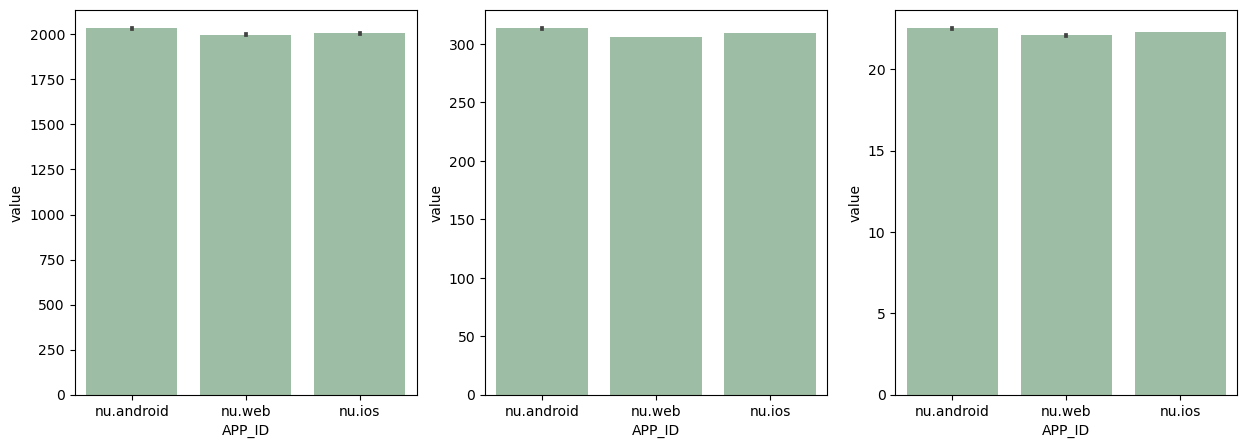

In [100]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
fig, axes= plt.subplots(1, 3, figsize=(15, 5))
with_outliers = True
ax0 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_chars"], color='#99c2a2', ax=axes[0])
ax1 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_words"], color='#99c2a2', ax=axes[1])
ax2 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_sentences"], color='#99c2a2', ax=axes[2])
# for ax in [ax0,ax1,ax2]:
#     ax.set_xlim()

plt.show()



# Correlation device and time of day
A graph has been created showing at what time of day interactions took place per device type. The samples taken from each category are equal, since in the dataset nu.web occurs more frequently than nu.ios and nu.android.

In [101]:
# TODO: Remove
ddf3 = ddf_views[[ "APP_ID", "dt_hour"]].compute()
ddf3.head()

APP_ID  dt_hour
article_id                     
1005304         nu.web       10
1015214         nu.web       21
101809          nu.web       22
102273      nu.android       17
1028382         nu.web       17

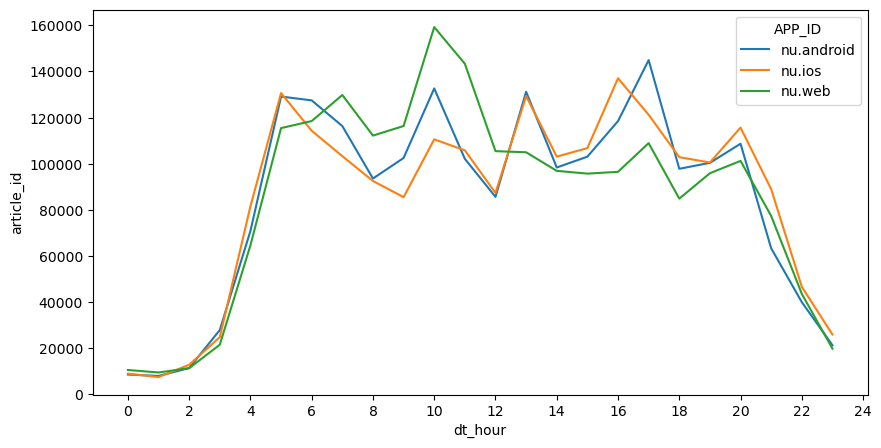

In [104]:
# TODO: Add a normalized graph
stepsize = 2
fig = plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="dt_hour", y="article_id", hue="APP_ID" ,data=ddf3.reset_index().groupby(["APP_ID", "dt_hour"]).agg("count"))
ax.xaxis.set_ticks(np.arange(0, 26, stepsize))
plt.show()

# Correlation device and topic
For a correlation between device type and topic, only the most prominent topic from the articles has been considered. Kruskal Wallis H reveals a signficant relation between the topics and device type.

In [108]:
ddf_topics_merged = ddf_topics.merge(ddf_views[["APP_ID"]], how='inner')#.persist()
ddf_topics_merged


Dask DataFrame Structure:
               topic_voetbal topic_optredens_en_voorstellingen topic_politiek topic_technologie_en_handel topic_relatie_en_opvoeden topic_bestuur_en_organisatie topic_human_interest topic_verkeersongevallen topic_nominatie_en_prijzen topic_veiligheid topic_onderwijs topic_maatschappelijke_instellingen topic_economie topic_lokale_evenementen topic_het_weer topic_brand topic_verkeer topic_gezondheid_en_zorg topic_gemeentepolitiek topic_sport topic_kunst_en_cultuur topic_eten_en_drinken topic_natuur topic_duurzaamheid topic_misdaad topic_wielrennen topic_zingeving_en_verhalen topic_afval_en_milieuproblematiek topic_consumeren_en_vrije_tijd topic_overheidsbeleid topic_vakbond_club_en_vereniging topic_religie topic_bouwen_en_wonen topic_recht_en_justitie topic_samenleving topic_woon_en_leefomgeving file_name article_topic_entropy argmax_topic  APP_ID
npartitions=14                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1005304              float64                           float64        float64                     float64                   float64                      float64              float64                  float64                    float64          float64         float64                             float64        float64                  float64        float64     float64       float64                  float64                float64     float64                float64               float64      float64            float64       float64          float64                     float64                           float64                        float64               float64                          float64       float64               float64                 float64           float64                    float64     int64               float64       object  object
1013291                  ...                               ...            ...                         ...                       ...                          ...                  ...                      ...                        ...              ...             ...                                 ...            ...                      ...            ...         ...           ...                      ...                    ...         ...                    ...                   ...          ...                ...           ...              ...                         ...                               ...                            ...                   ...                              ...           ...                   ...                     ...               ...                        ...       ...                   ...          ...     ...
...                      ...                               ...            ...                         ...                       ...                          ...                  ...                      ...                        ...              ...             ...                                 ...            ...                      ...            ...         ...           ...                      ...                    ...         ...                    ...                   ...          ...                ...           ...        

3it [00:08,  2.97s/it]


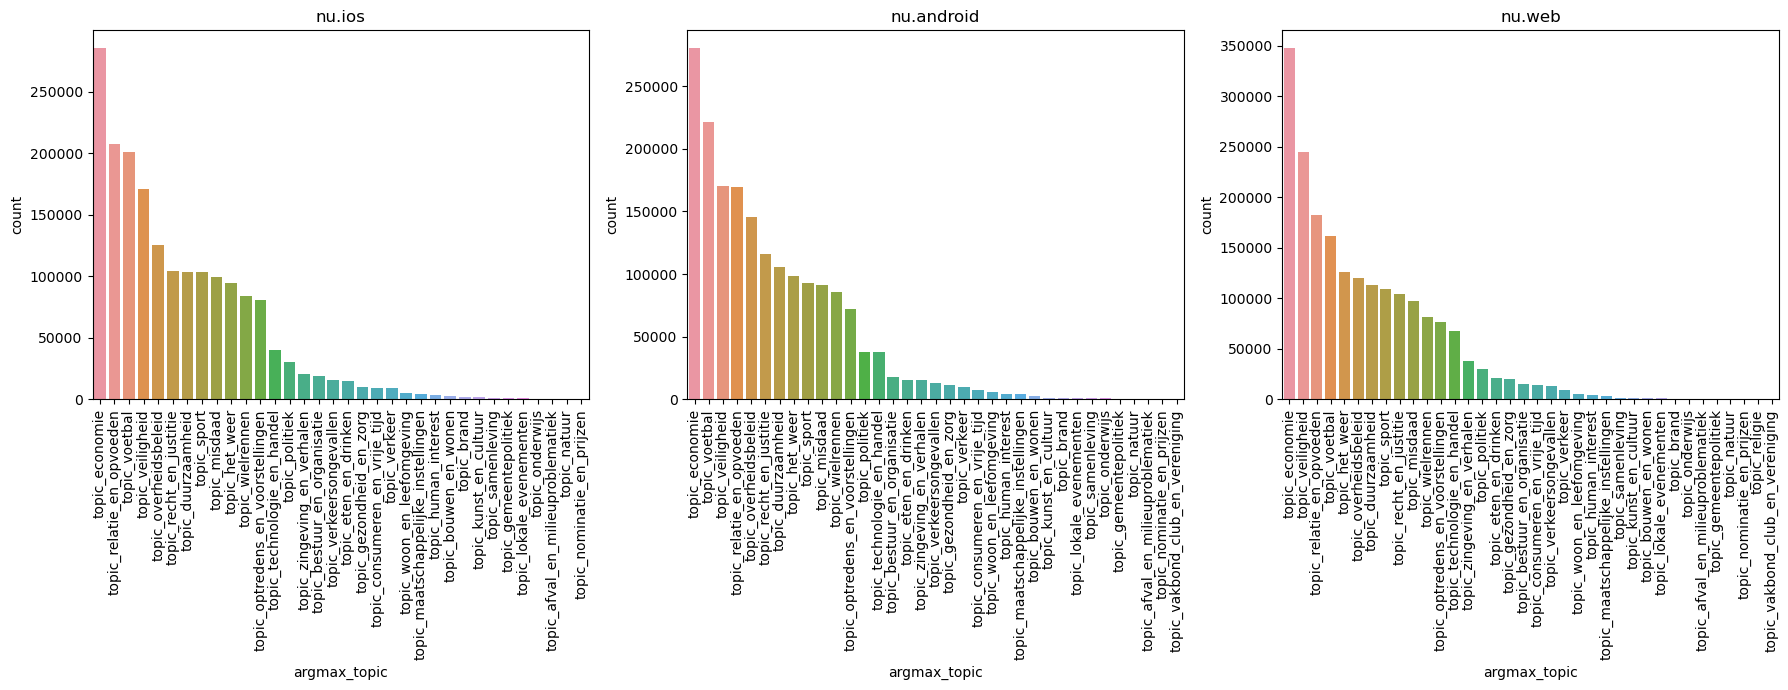

In [109]:
fig, axes = plt.subplots(1,3, figsize=(18, 7))
faxes = axes.flatten()
tmp = ddf_topics_merged[["argmax_topic", "APP_ID"]].compute()
for device, ax in tqdm.tqdm(zip(unique_devices, faxes)):
    order = tmp.loc[tmp["APP_ID"]==device]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["APP_ID"]==device], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(device)
fig.tight_layout()
plt.show()

In [110]:
l_test_results = list()
tmp = ddf_topics_merged.sample(frac=1).compute()
for topic in tqdm.tqdm(topic_columns):
    res = {"topic": topic, **pg.kruskal(data=tmp, dv=topic, between="APP_ID").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 36/36 [03:52<00:00,  6.45s/it]


topic  Source  ddof1             H  \
0                         topic_voetbal  APP_ID      2   5453.249801   
22                         topic_natuur  APP_ID      2  11913.760866   
21                topic_eten_en_drinken  APP_ID      2   8835.506929   
20               topic_kunst_en_cultuur  APP_ID      2   1681.232225   
18               topic_gemeentepolitiek  APP_ID      2   2461.650563   
34                    topic_samenleving  APP_ID      2   6424.648974   
16                        topic_verkeer  APP_ID      2   3199.956374   
15                          topic_brand  APP_ID      2   2751.943696   
26          topic_zingeving_en_verhalen  APP_ID      2   6534.984677   
23                   topic_duurzaamheid  APP_ID      2   6472.631726   
27    topic_afval_en_milieuproblematiek  APP_ID      2   9920.787560   
12                       topic_economie  APP_ID      2   6286.171757   
9                      topic_veiligheid  APP_ID      2  26630.567844   
8            topic_nominatie_en_prijzen  APP_ID      2  14732.391933   
7              topic_verkeersongevallen  APP_ID      2   7881.551907   
6                  topic_human_interest  APP_ID      2   5280.599316   
30     topic_vakbond_club_en_vereniging  APP_ID      2   3594.039261   
4             topic_relatie_en_opvoeden  APP_ID      2   7620.585652   
3           topic_technologie_en_handel  APP_ID      2  12233.475471   
32                topic_bouwen_en_wonen  APP_ID      2   5229.586648   
1     topic_optredens_en_voorstellingen  APP_ID      2   4894.690566   
29                topic_overheidsbeleid  APP_ID      2   1734.504034   
24                        topic_misdaad  APP_ID      2   3437.945701   
13             topic_lokale_evenementen  APP_ID      2   1310.959596   
25                     topic_wielrennen  APP_ID      2   1004.505705   
17             topic_gezondheid_en_zorg  APP_ID      2    875.342929   
2                        topic_politiek  APP_ID      2    777.144667   
10                      topic_onderwijs  APP_ID      2    772.590890   
33              topic_recht_en_justitie  APP_ID      2    719.572451   
14                       topic_het_weer  APP_ID      2    635.467798   
31                        topic_religie  APP_ID      2    454.741716   
28       topic_consumeren_en_vrije_tijd  APP_ID      2    317.519757   
5          topic_bestuur_en_organisatie  APP_ID      2    314.980085   
11  topic_maatschappelijke_instellingen  APP_ID      2    298.467598   
19                          topic_sport  APP_ID      2     24.014860   
35           topic_woon_en_leefomgeving  APP_ID      2     15.507856   

            p-unc  
0    0.000000e+00  
22   0.000000e+00  
21   0.000000e+00  
20   0.000000e+00  
18   0.000000e+00  
34   0.000000e+00  
16   0.000000e+00  
15   0.000000e+00  
26   0.000000e+00  
23   0.000000e+00  
27   0.000000e+00  
12   0.000000e+00  
9    0.000000e+00  
8    0.000000e+00  
7    0.000000e+00  
6    0.000000e+00  
30   0.000000e+00  
4    0.000000e+00  
3    0.000000e+00  
32   0.000000e+00  
1    0.000000e+00  
29   0.000000e+00  
24   0.000000e+00  
13  2.131771e-285  
25  7.487857e-219  
17  8.350221e-191  
2   1.758651e-169  
10  1.714036e-168  
33  5.582486e-157  
14  1.023107e-138  
31   1.795109e-99  
28   1.125799e-69  
5    4.008147e-69  
11   1.543777e-65  
19   6.098730e-06  
35   4.290539e-04

100%|██████████| 36/36 [00:04<00:00,  7.93it/s]


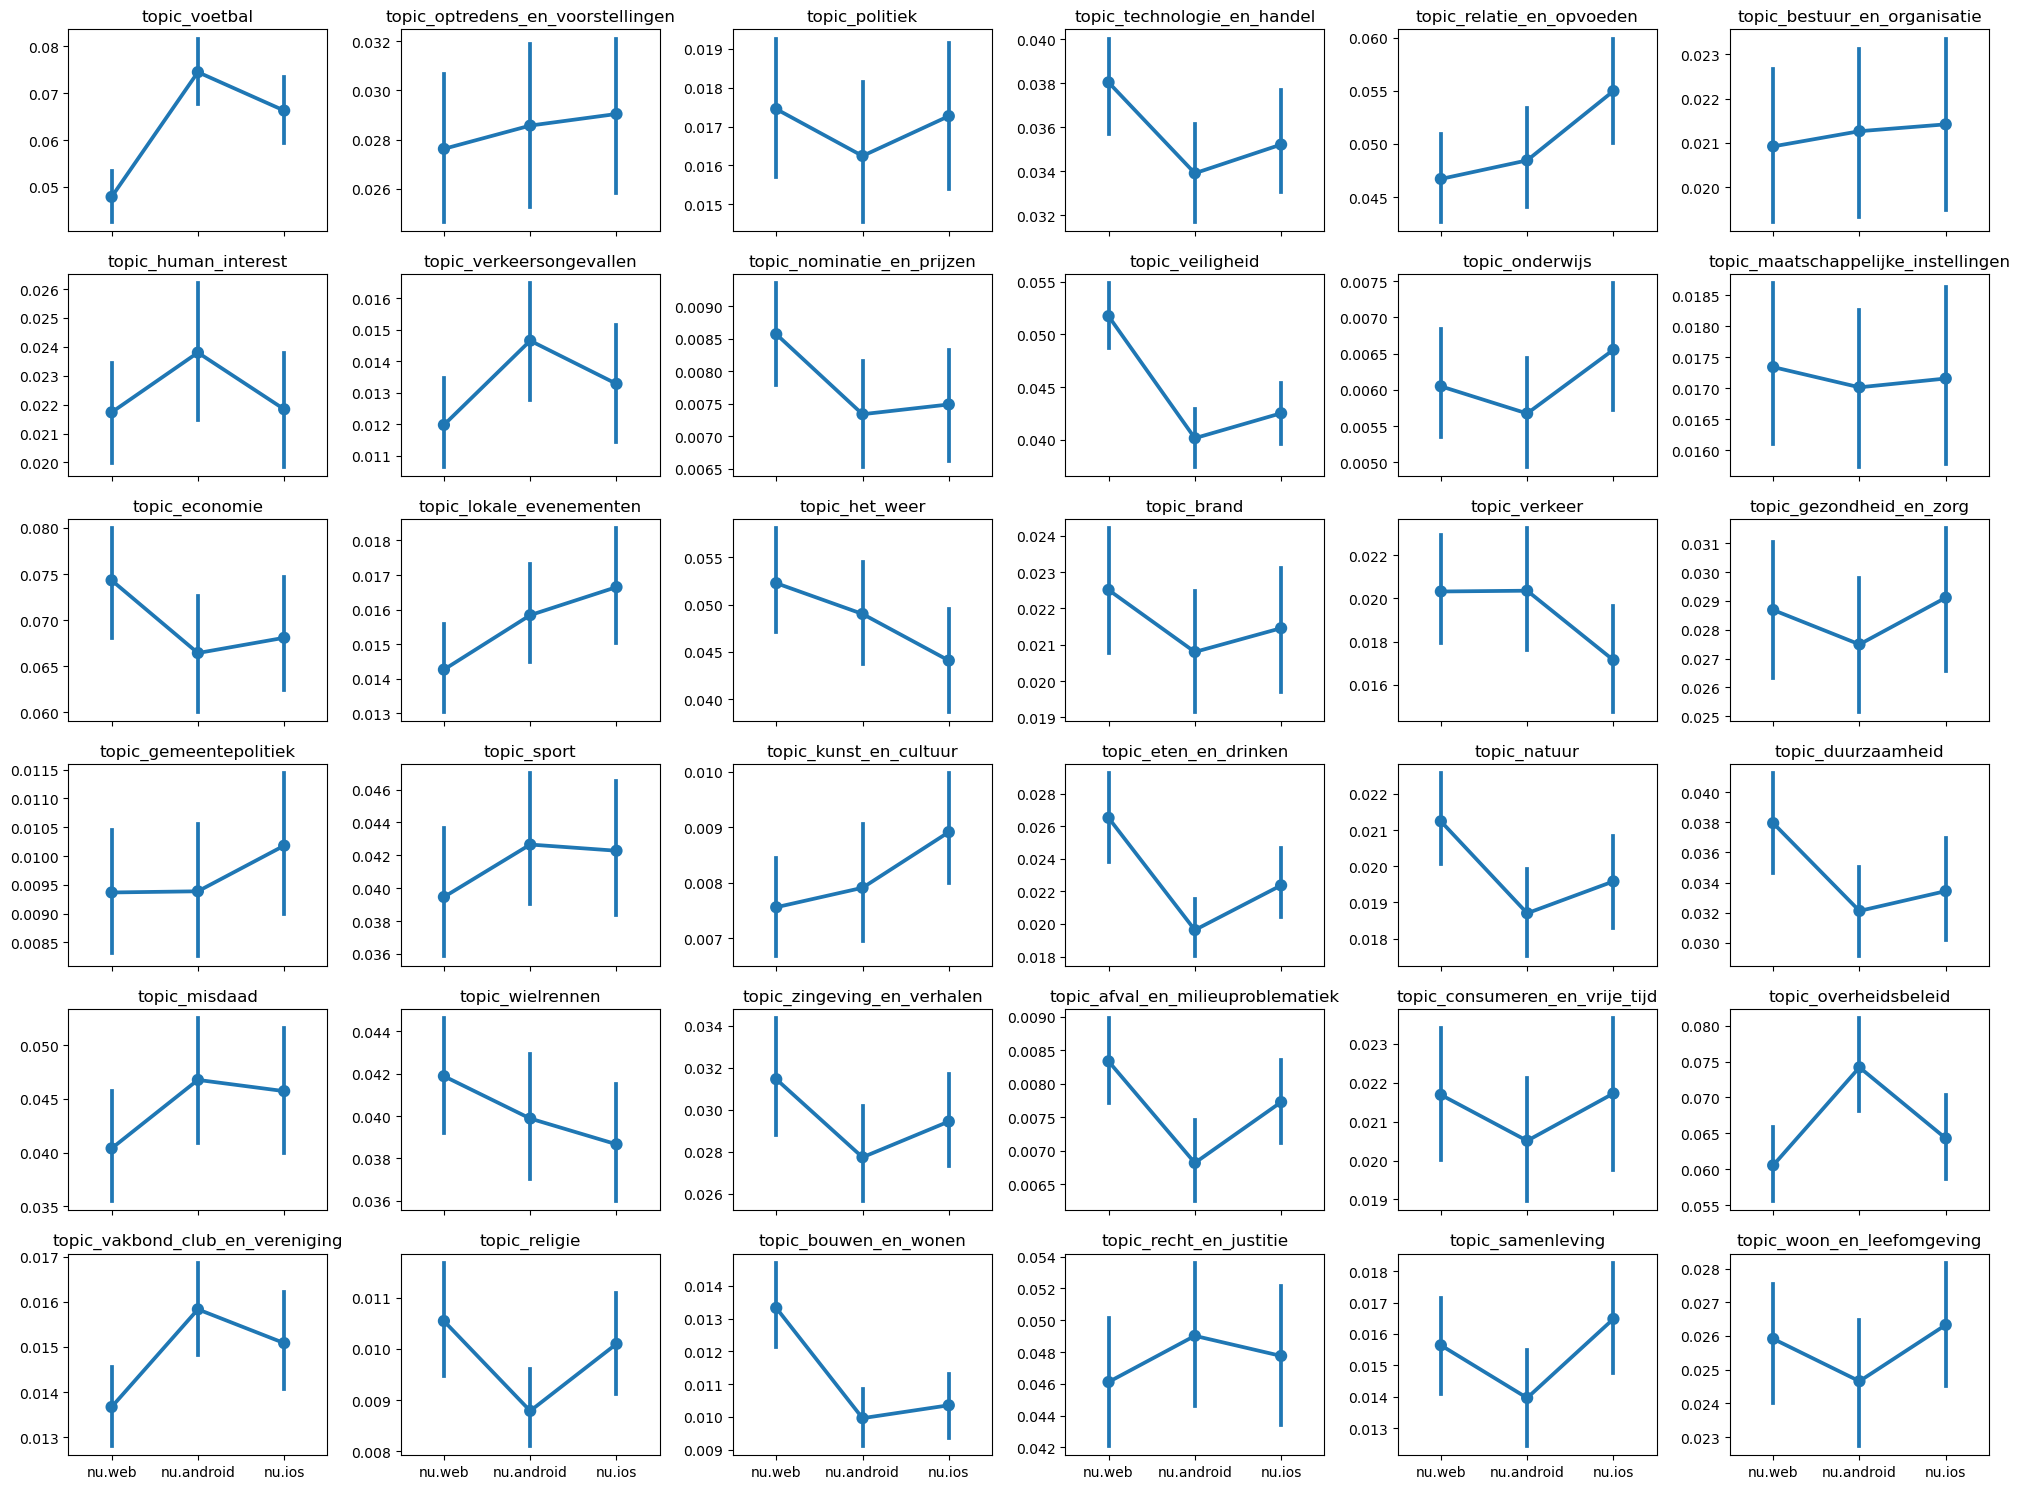

In [111]:
# TODO: Correct the yscales
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged.sample(frac=0.001).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="APP_ID", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(topic)
fig.tight_layout()  
plt.show()

# Correlation device and topic diversity
Topic diversity has been measured in terms of article entropy. The means of the entropies of articles across device types has been compared. Since it looks like a normal distribution, ANOVA has been applied. It results in a signficant p-value, but a low np2 means a small effect size.
There are no discernible clusters in a 2-dimensional space.


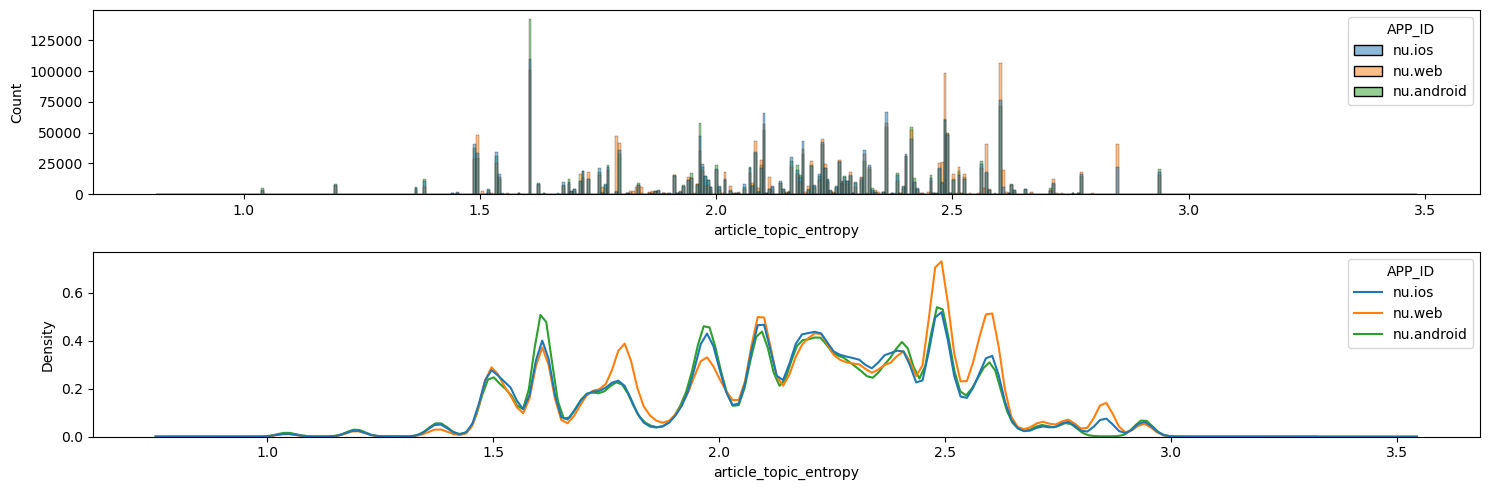

In [124]:
fig, axes = plt.subplots(2,1,figsize=(15, 5))
tmp = ddf_topics_merged.sample(frac=1).compute().reset_index()
sns.histplot(data=tmp, x="article_topic_entropy", hue="APP_ID", ax=axes[0])
sns.kdeplot(data=tmp, x="article_topic_entropy", hue="APP_ID", ax=axes[1])
fig.tight_layout()
plt.show()

In [113]:
# median_fun = pd.Aggregation(
#     name="median",
#     # this computes the median on each partition
#     chunk=lambda s: s.median(),
#     # this combines results across partitions; the input should just be a list of length 1
#     agg=lambda s0: s0.sum(),
# )
ddf_topics_merged[["APP_ID", "article_topic_entropy"]].groupby("APP_ID").agg(["mean", "std", "min", "max"]).compute()

article_topic_entropy                             
                            mean       std      min       max
APP_ID                                                       
nu.ios                  2.133225  0.363296  0.81376  3.482929
nu.android              2.117303  0.362434  0.81376  3.259468
nu.web                  2.169295  0.368163  0.81376  3.482929

In [114]:
tmp = ddf_topics_merged.compute()
pg.anova(data=tmp, dv='article_topic_entropy', between='APP_ID')

/home/bestname/anaconda3/envs/dpg/lib/python3.10/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean()) ** 2).sum()


Source  ddof1    ddof2             F  p-unc       np2
0  APP_ID      2  5713239  10370.441447    0.0  0.003617

<AxesSubplot: xlabel='APP_ID', ylabel='article_topic_entropy'>

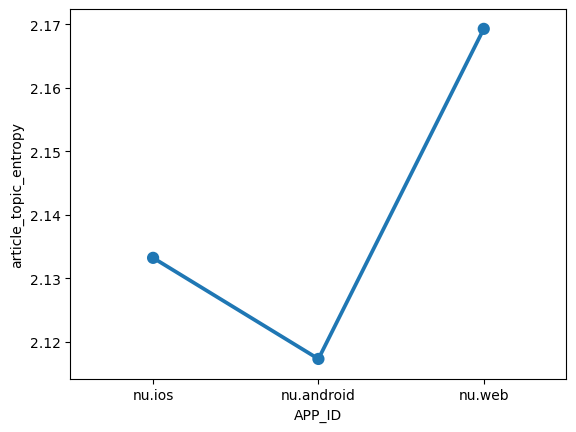

In [115]:
fig, ax = plt.subplots(1,1)
sns.pointplot(data=tmp, x="APP_ID", y='article_topic_entropy', ax=ax)

In [116]:
centroids = ddf_topics_merged[["APP_ID"]+list(topic_columns)].groupby("APP_ID").agg(np.mean).compute()
centroids

topic_voetbal  topic_optredens_en_voorstellingen  topic_politiek  \
APP_ID                                                                         
nu.ios           0.064363                           0.029443        0.016871   
nu.android       0.071537                           0.026558        0.017775   
nu.web           0.048184                           0.026296        0.017516   

            topic_technologie_en_handel  topic_relatie_en_opvoeden  \
APP_ID                                                               
nu.ios                         0.034430                   0.054674   
nu.android                     0.035310                   0.047368   
nu.web                         0.037654                   0.048807   

            topic_bestuur_en_organisatie  topic_human_interest  \
APP_ID                                                           
nu.ios                          0.021695              0.022565   
nu.android                      0.021684              0.021487   
nu.web                          0.020399              0.021409   

            topic_verkeersongevallen  topic_nominatie_en_prijzen  \
APP_ID                                                             
nu.ios                      0.013403                    0.007594   
nu.android                  0.012787                    0.007367   
nu.web                      0.012030                    0.008162   

            topic_veiligheid  ...  topic_zingeving_en_verhalen  \
APP_ID                        ...                                
nu.ios              0.042552  ...                     0.029438   
nu.android          0.043870  ...                     0.026961   
nu.web              0.051903  ...                     0.031518   

            topic_afval_en_milieuproblematiek  topic_consumeren_en_vrije_tijd  \
APP_ID                                                                          
nu.ios                               0.007592                        0.021254   
nu.android                           0.007237                        0.020974   
nu.web                               0.008189                        0.022350   

            topic_overheidsbeleid  topic_vakbond_club_en_vereniging  \
APP_ID                                                                
nu.ios                   0.064480                          0.015377   
nu.android               0.070954                          0.016075   
nu.web                   0.062668                          0.014032   

            topic_religie  topic_bouwen_en_wonen  topic_recht_en_justitie  \
APP_ID                                                                      
nu.ios           0.010466               0.010645                 0.046106   
nu.android       0.009303               0.010511                 0.047464   
nu.web           0.010575               0.012530                 0.045756   

            topic_samenleving  topic_woon_en_leefomgeving  
APP_ID                                                     
nu.ios               0.016358                    0.026261  
nu.android           0.014954                    0.026146  
nu.web               0.016949                    0.026861  

[3 rows x 36 columns]

In [117]:
# https://github.com/silviatti/topic-model-diversity
X = centroids.values
pd.DataFrame(cdist(X,X, "euclidean"), index=centroids.index, columns=centroids.index)

APP_ID        nu.ios  nu.android    nu.web
APP_ID                                    
nu.ios      0.000000    0.013629  0.024570
nu.android  0.013629    0.000000  0.030332
nu.web      0.024570    0.030332  0.000000

In [118]:
# https://github.com/silviatti/topic-model-diversity
X = centroids.values
pd.DataFrame(cdist(X,X, "cosine"), index=centroids.index, columns=centroids.index)

APP_ID        nu.ios  nu.android    nu.web
APP_ID                                    
nu.ios      0.000000    0.002335  0.007931
nu.android  0.002335    0.000000  0.011854
nu.web      0.007931    0.011854  0.000000

<AxesSubplot: >

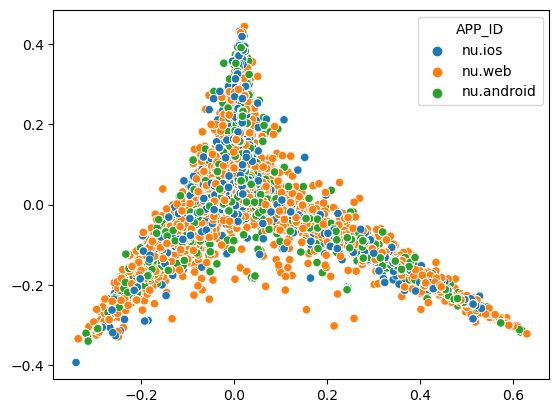

In [119]:
from sklearn.decomposition import PCA
reducer = PCA(2)
data = ddf_topics_merged.sample(frac=1).dropna().compute()
reduced_data = reducer.fit_transform(data[list(topic_columns)])
sns.scatterplot(x = reduced_data[:, 0], y = reduced_data[:, 1], hue=data["APP_ID"])

# Correlation device and USERNEEDS
Kruskal Wallis H reveals a signficant p-value for all the different userneeds across device types

In [125]:
ddf_userneeds_merged = ddf_userneeds.merge(ddf_views[["APP_ID"]])
ddf_userneeds_merged

Dask DataFrame Structure:
               userneed_hou_me_op_de_hoogte userneed_geef_me_context userneed_vermaak_me userneed_raak_me_verbind_me userneed_help_me file_name argmax_userneeds  APP_ID
npartitions=14                                                                                                                                                          
1005304                             float64                  float64             float64                     float64          float64     int64           object  object
1013291                                 ...                      ...                 ...                         ...              ...       ...              ...     ...
...                                     ...                      ...                 ...                         ...              ...       ...              ...     ...
962788                                  ...                      ...                 ...                         ...              ...       ...              ...     ...
TNwse80V                                ...                      ...                 ...                         ...              ...       ...              ...     ...
Dask Name: join-indexed, 46 graph layers

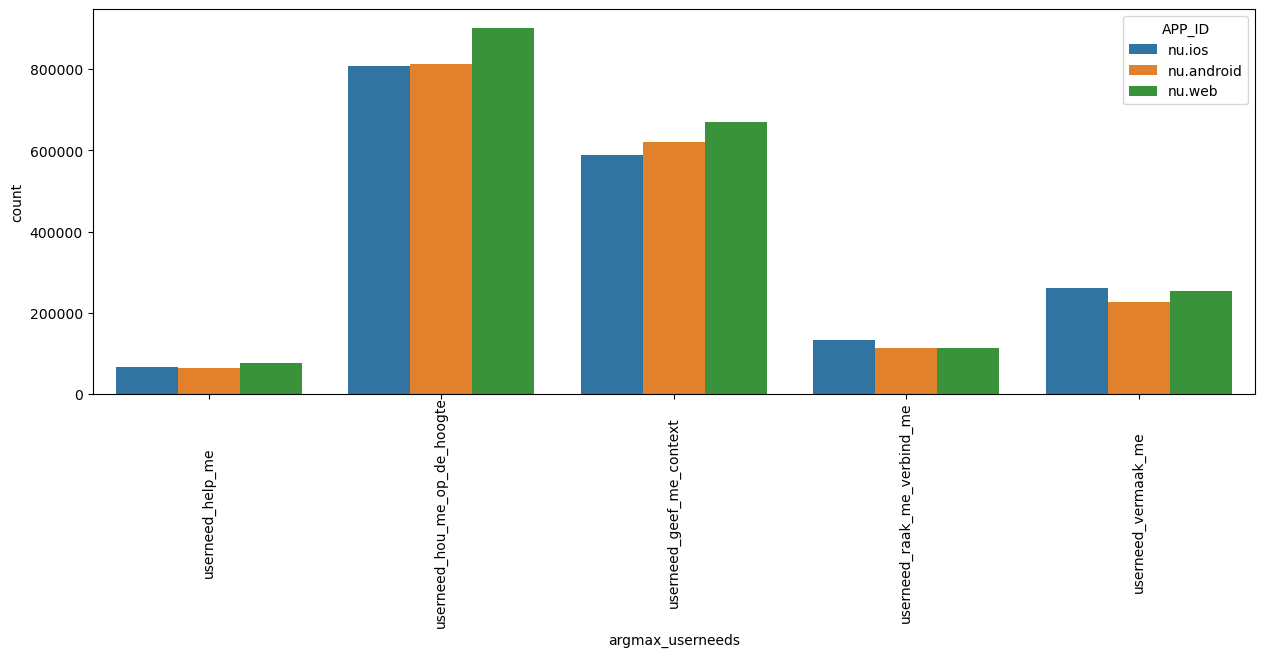

In [126]:
fig, axes = plt.subplots(1,1,figsize=(15, 5))
tmp = ddf_userneeds_merged[["argmax_userneeds", "APP_ID"]].compute()
ax = sns.countplot(data=tmp, x="argmax_userneeds", hue="APP_ID", ax=axes)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, va="center", position=(0,-0.28))
plt.show()

In [127]:
l_test_results = list()
tmp = ddf_userneeds_merged.sample(frac=0.1).compute()
for need in tqdm.tqdm(columns_userneeds):
    res = {"need": need, **pg.kruskal(data=tmp, dv=need, between="APP_ID").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


need  Source  ddof1           H          p-unc
3   userneed_raak_me_verbind_me  APP_ID      2  460.931176  8.129558e-101
2           userneed_vermaak_me  APP_ID      2  455.476981   1.242883e-99
1      userneed_geef_me_context  APP_ID      2  367.340048   1.710496e-80
4              userneed_help_me  APP_ID      2  166.122947   8.450073e-37
0  userneed_hou_me_op_de_hoogte  APP_ID      2  101.424031   9.463492e-23

100%|██████████| 5/5 [00:30<00:00,  6.04s/it]


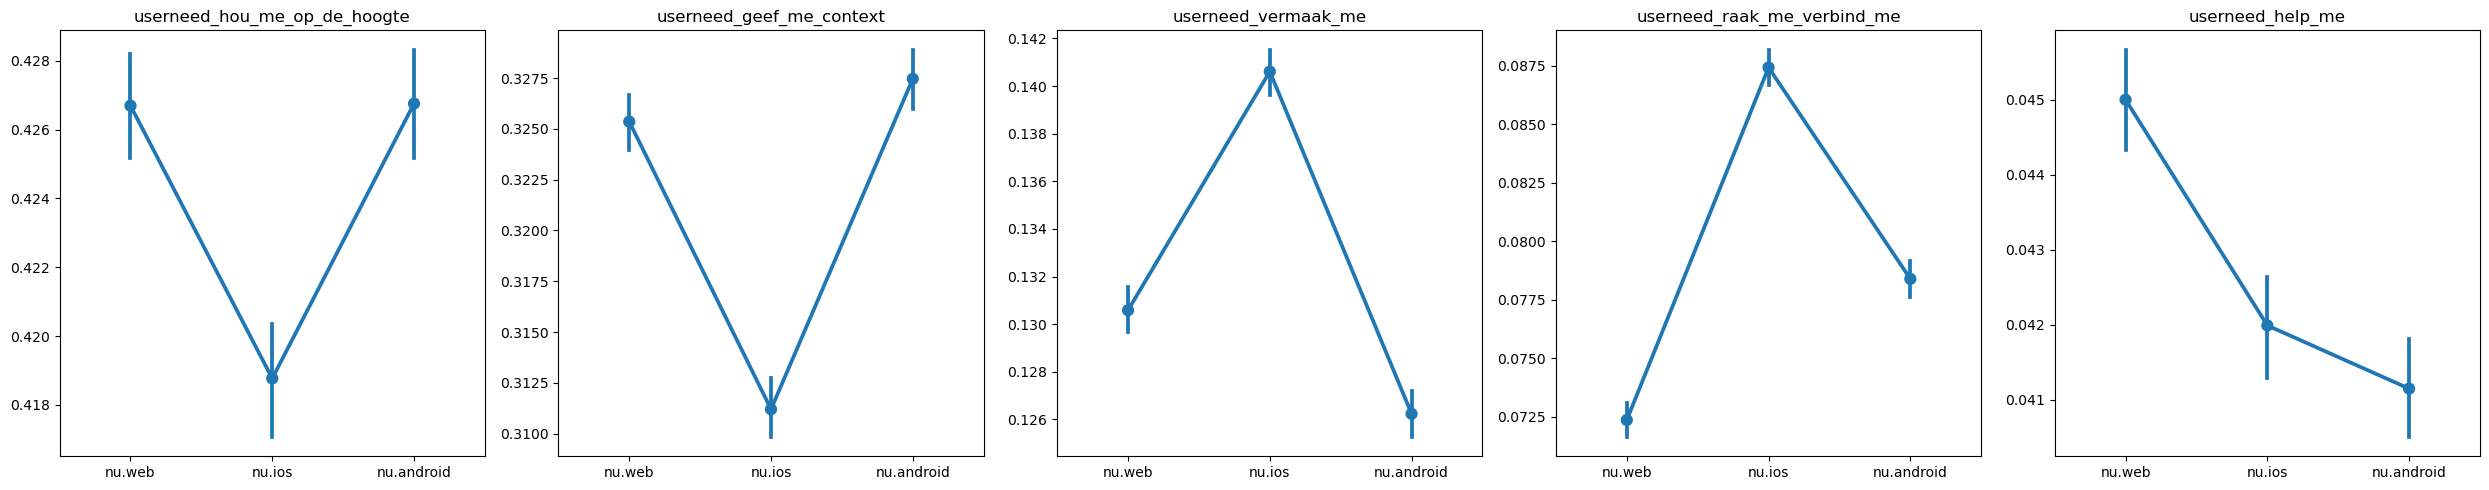

In [128]:
fig, axes = plt.subplots(1, len(columns_userneeds),figsize=(25, 5), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_userneeds_merged.sample(frac=0.1).compute()
for need, ax in tqdm.tqdm(zip(columns_userneeds, faxes), total=len(columns_userneeds)):
    ax = sns.pointplot(data=tmp, x="APP_ID", y=need, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(need)
fig.tight_layout()  
plt.show()

# SENSITIVE ARTICLES

/home/bestname/anaconda3/envs/dpg/lib/python3.10/site-packages/dask/dataframe/core.py:6751: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


sensitive_topic_adult  sensitive_topic_arms  \
article_id                                                
537071                        0.0              0.000000   
962788                        0.0              0.074435   
1013291                       0.0              0.000000   
1149251                       0.0              0.000000   
1401797                       0.0              0.000000   

            sensitive_topic_crime  sensitive_topic_death  \
article_id                                                 
537071                        0.0               0.000000   
962788                        0.0               0.000000   
1013291                       0.0               0.000000   
1149251                       0.0               0.000000   
1401797                       0.0               0.132023   

            sensitive_topic_drugs  sensitive_topic_hate_speech  \
article_id                                                       
537071                        0.0                          0.0   
962788                        0.0                          0.0   
1013291                       0.0                          0.0   
1149251                       0.0                          0.0   
1401797                       0.0                          0.0   

            sensitive_topic_obscenity  sensitive_topic_piracy  \
article_id                                                      
537071                       0.000000                     0.0   
962788                       0.074531                     0.0   
1013291                      0.000000                     0.0   
1149251                      0.000000                     0.0   
1401797                      0.000000                     0.0   

            sensitive_topic_sensitive  sensitive_topic_social_issue  \
article_id                                                            
537071                            0.0                      0.500000   
962788                            0.0                      0.425517   
1013291                           0.0                      0.341225   
1149251                           0.0                      0.000000   
1401797                           0.0                      0.433988   

            sensitive_topic_terrorism  \
article_id                              
537071                            0.0   
962788                            0.0   
1013291                           0.0   
1149251                           0.0   
1401797                           0.0   

            sensitive_topic_sensitive_and_social_issue  \
article_id                                               
537071                                        0.500000   
962788                                        0.425517   
1013291                                       0.341225   
1149251                                       0.000000   
1401797                                       0.433988   

            sensitive_topic_spam_and_harmful_content  file_name  \
article_id                                                        
537071                                      0.000000          3   
962788                                      0.000000          1   
1013291                                     0.317549          2   
1149251                                     0.000000          3   
1401797                                     0.000000          3   

                      argmax_sensitivity  is_sensitive  \
article_id                                               
537071      sensitive_topic_social_issue           1.0   
962788      sensitive_topic_social_issue           1.0   
1013291     sensitive_topic_social_issue           1.0   
1149251            sensitive_topic_adult           0.0   
1401797     sensitive_topic_social_issue           1.0   

            article_sensitivity_entropy  
article_id                               
537071                         0.693147  
962788                         1.114059  
1013291             

In [129]:
ddf_sensitivity_merged = ddf_sensitivity.merge(ddf_views[["APP_ID"]], how="inner")
ddf_sensitivity_merged

Dask DataFrame Structure:
               sensitive_topic_adult sensitive_topic_arms sensitive_topic_crime sensitive_topic_death sensitive_topic_drugs sensitive_topic_hate_speech sensitive_topic_obscenity sensitive_topic_piracy sensitive_topic_sensitive sensitive_topic_social_issue sensitive_topic_terrorism sensitive_topic_sensitive_and_social_issue sensitive_topic_spam_and_harmful_content file_name argmax_sensitivity is_sensitive article_sensitivity_entropy  APP_ID
npartitions=14                                                                                                                                                                                                                                                                                                                                                                                                                                             
1005304                      float64              float64               float64               float64               float64                     float64                   float64                float64                   float64                      float64                   float64                                    float64                                  float64     int64             object      float64                     float64  object
1013291                          ...                  ...                   ...                   ...                   ...                         ...                       ...                    ...                       ...                          ...                       ...                                        ...                                      ...       ...                ...          ...                         ...     ...
...                              ...                  ...                   ...                   ...                   ...                         ...                       ...                    ...                       ...                          ...                       ...                                        ...                                      ...       ...                ...          ...                         ...     ...
962788                           ...                  ...                   ...                   ...                   ...                         ...                       ...                    ...                       ...                          ...                       ...                                        ...                                      ...       ...                ...          ...                         ...     ...
TNwse80V                         ...                  ...                   ...                   ...                   ...                         ...                       ...                    ...                       ...                          ...                       ...                                        ...                                      ...       ...                ...          ...                         ...     ...
Dask Name: join-indexed, 53 graph layers

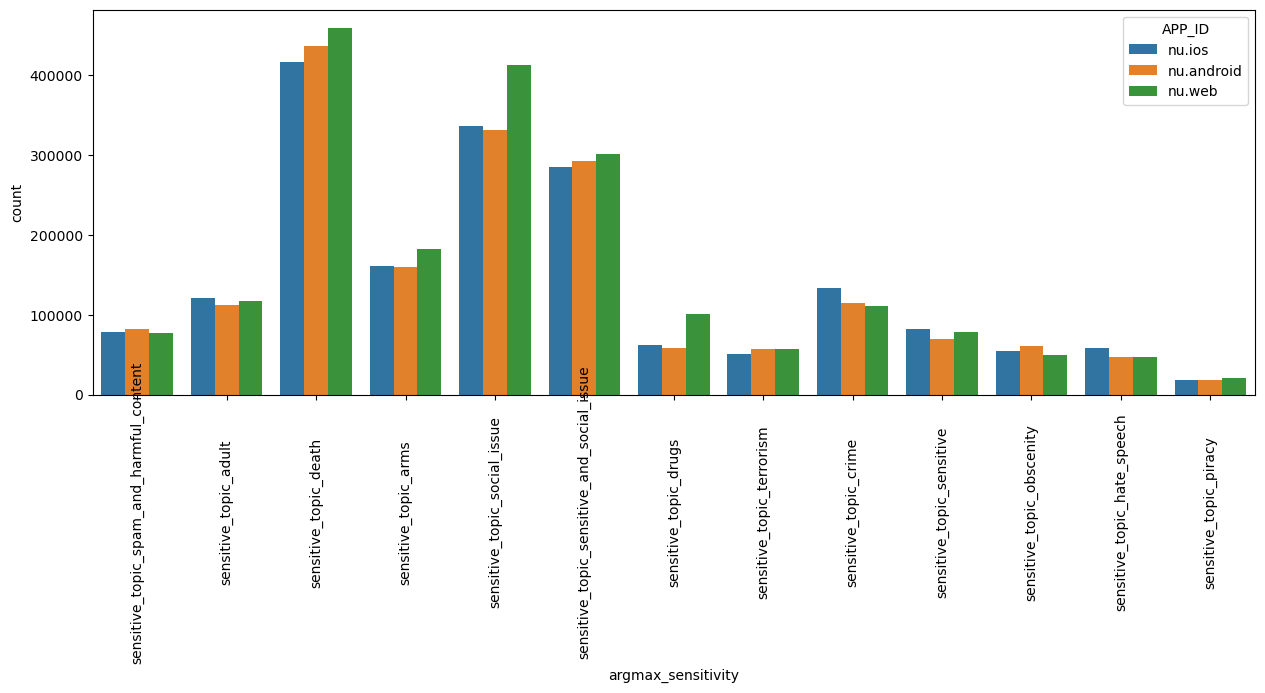

In [130]:
fig, axes = plt.subplots(1,1,figsize=(15, 5))
tmp = ddf_sensitivity_merged[["argmax_sensitivity", "APP_ID"]].compute()
ax = sns.countplot(data=tmp, x="argmax_sensitivity", hue="APP_ID", ax=axes)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, va="center", position=(0,-0.28))
plt.show()

In [131]:
l_test_results = list()
tmp = ddf_sensitivity_merged.sample(frac=0.1).compute()
for sensitivity in tqdm.tqdm(columns_sensitivity):
    res = {"need": need, **pg.kruskal(data=tmp, dv=sensitivity, between="APP_ID").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


need  Source  ddof1           H         p-unc
2   userneed_help_me  APP_ID      2  375.458135  2.953262e-82
0   userneed_help_me  APP_ID      2  269.689420  2.739596e-59
12  userneed_help_me  APP_ID      2  237.435666  2.763759e-52
7   userneed_help_me  APP_ID      2  202.956738  8.482116e-45
5   userneed_help_me  APP_ID      2  172.029388  4.408523e-38
8   userneed_help_me  APP_ID      2  137.528748  1.367766e-30
3   userneed_help_me  APP_ID      2  125.150390  6.667116e-28
9   userneed_help_me  APP_ID      2   92.571328  7.913920e-21
10  userneed_help_me  APP_ID      2   57.934010  2.628994e-13
6   userneed_help_me  APP_ID      2   50.925662  8.742446e-12
1   userneed_help_me  APP_ID      2   40.655337  1.485271e-09
11  userneed_help_me  APP_ID      2   33.031740  6.718137e-08
4   userneed_help_me  APP_ID      2   28.352799  6.970563e-07

100%|██████████| 13/13 [01:44<00:00,  8.04s/it]


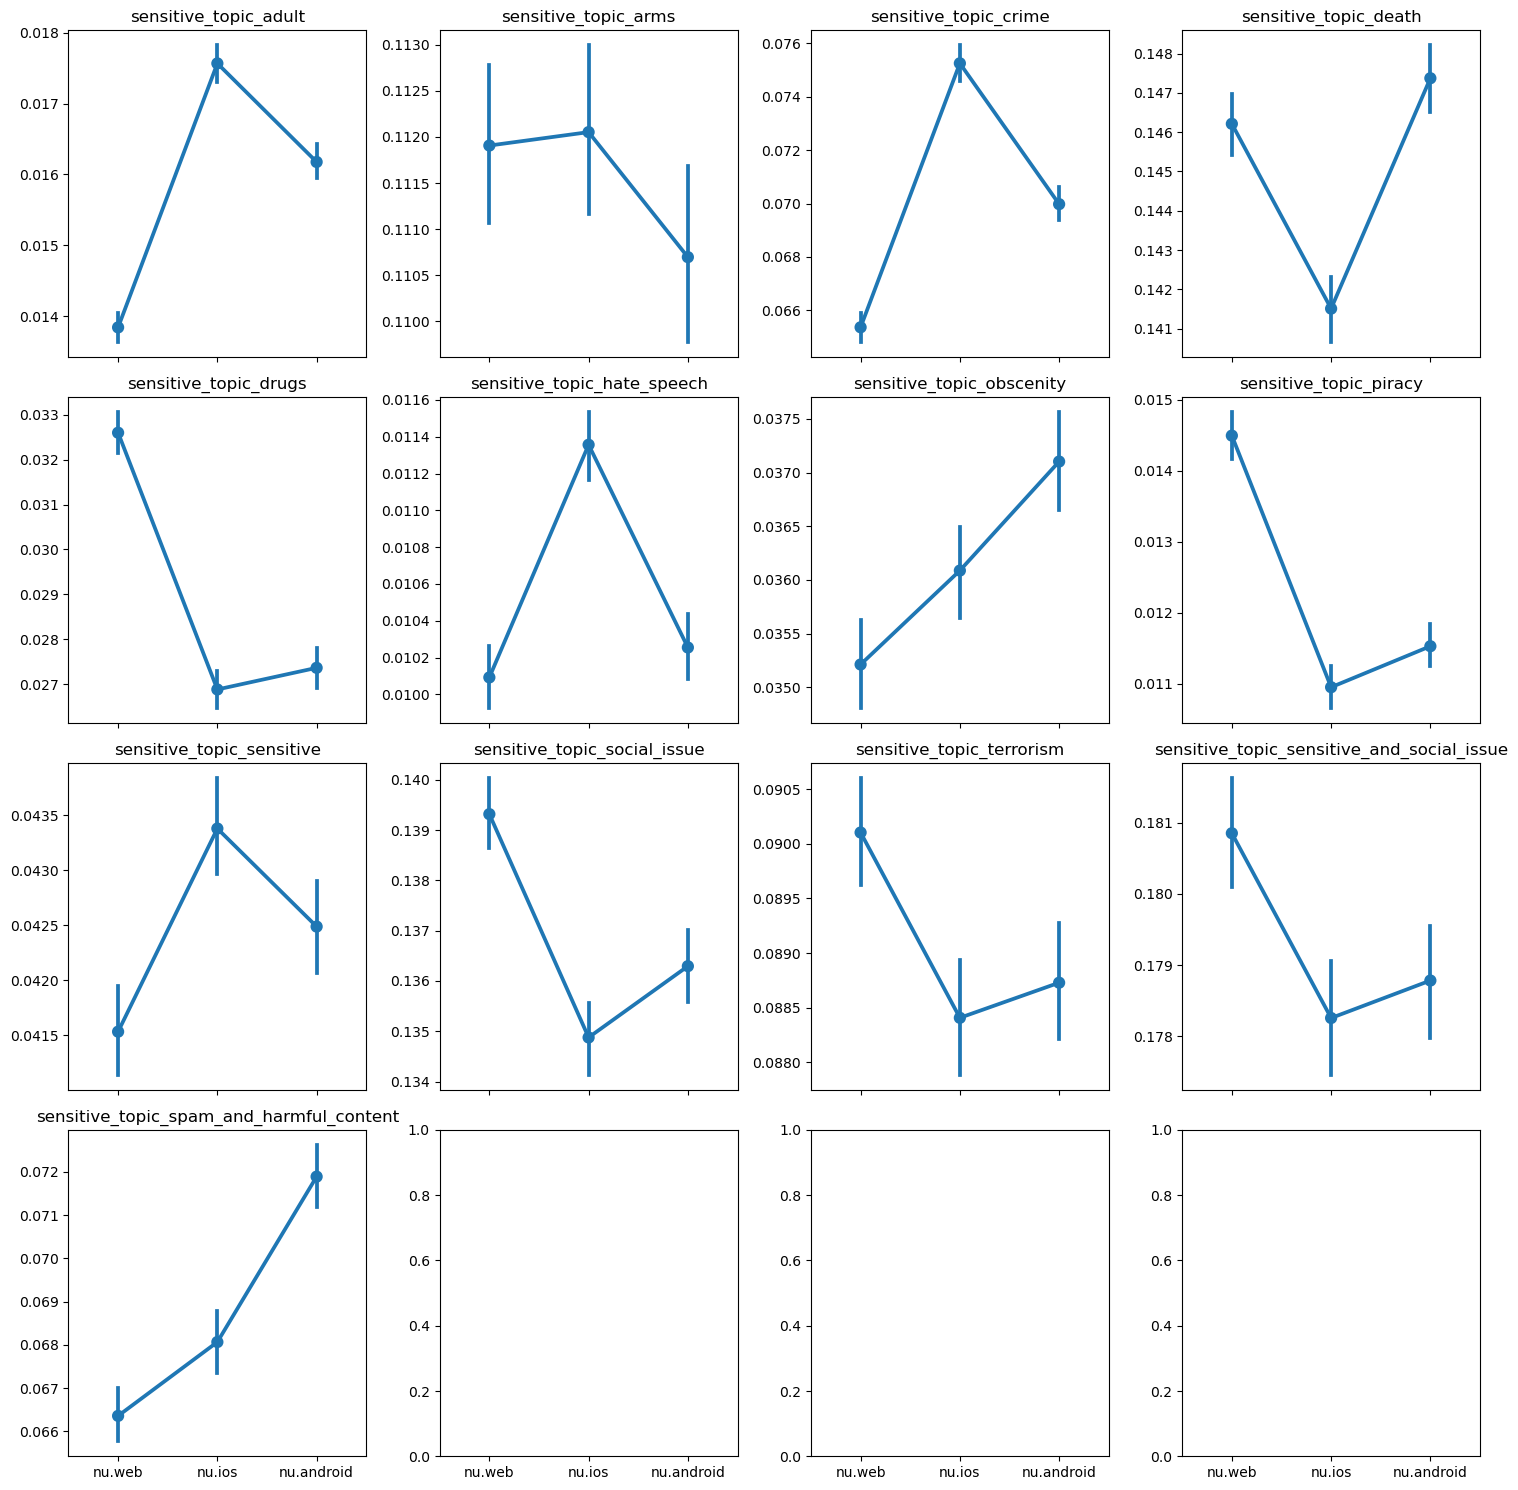

In [132]:
fig, axes = plt.subplots(4, 4,figsize=(15, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_sensitivity_merged.sample(frac=0.1).compute()
for sensitivity, ax in tqdm.tqdm(zip(columns_sensitivity, faxes), total=len(columns_sensitivity)):
    ax = sns.pointplot(data=tmp, x="APP_ID", y=sensitivity, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(sensitivity)
fig.tight_layout()  
plt.show()

In [133]:
tmp

sensitive_topic_adult  sensitive_topic_arms  \
article_id                                                
6177365                  0.000000              0.000000   
6177365                  0.000000              0.000000   
6177365                  0.000000              0.000000   
6190832                  0.000000              0.000000   
6188592                  0.000000              0.287228   
...                           ...                   ...   
6192831                  0.000000              0.000000   
6192812                  0.036505              0.092522   
6192844                  0.000000              0.497974   
6192812                  0.036505              0.092522   
6192818                  0.000000              0.000000   

            sensitive_topic_crime  sensitive_topic_death  \
article_id                                                 
6177365                  0.000000               0.000000   
6177365                  0.000000               0.000000   
6177365                  0.000000               0.000000   
6190832                  0.099647               0.200500   
6188592                  0.000000               0.550369   
...                           ...                    ...   
6192831                  0.000000               0.000000   
6192812                  0.264102               0.290439   
6192844                  0.502026               0.000000   
6192812                  0.264102               0.290439   
6192818                  0.000000               0.657572   

            sensitive_topic_drugs  sensitive_topic_hate_speech  \
article_id                                                       
6177365                  0.000000                     0.000000   
6177365                  0.000000                     0.000000   
6177365                  0.000000                     0.000000   
6190832                  0.160016                     0.165062   
6188592                  0.000000                     0.000000   
...                           ...                          ...   
6192831                  0.000000                     0.000000   
6192812                  0.000000                     0.000000   
6192844                  0.000000                     0.000000   
6192812                  0.000000                     0.000000   
6192818                  0.000000                     0.000000   

            sensitive_topic_obscenity  sensitive_topic_piracy  \
article_id                                                      
6177365                           0.0                     0.0   
6177365                           0.0                     0.0   
6177365                           0.0                     0.0   
6190832                           0.0                     0.0   
6188592                           0.0                     0.0   
...                               ...                     ...   
6192831                           0.0                     0.0   
6192812                           0.0                     0.0   
6192844                           0.0                     0.0   
6192812                           0.0                     0.0   
6192818                           0.0                     0.0   

            sensitive_topic_sensitive  sensitive_topic_social_issue  \
article_id                                                            
6177365                           0.0                      0.000000   
6177365                           0.0                      0.000000   
6177365                           0.0                      0.000000   
6190832                           0.0                      0.055315   
6188592                           0.0                      0.000000   
...                               ...                           ...   
6192831                           0.0                      0.000000   
6192812                           0.0                      0.055101   
6192844                           0.0           

# LOCATION

In [135]:
# https://pypi.org/project/pgeocode/
# https://www.cbs.nl/en-gb/our-services/open-data/statline-as-open-data/cartography
ddf_location = ddf_views[["GEO_CITY","GEO_COUNTRY","GEO_REGION","GEO_ZIPCODE", "APP_ID", "ARTICLE_ID"]].dropna(subset="GEO_ZIPCODE")
ddf_location["article_id"] = ddf_location["ARTICLE_ID"]
ddf_location["postal_code"] = ddf_location["GEO_ZIPCODE"]
ddf_location = ddf_location.set_index("postal_code")
display(ddf_location.head())
display(ddf_location)

GEO_CITY GEO_COUNTRY GEO_REGION GEO_ZIPCODE      APP_ID  \
postal_code                                                            
00-019           2478          PL         14      00-019  nu.android   
00-019           2478          PL         14      00-019  nu.android   
00-019           2478          PL         14      00-019  nu.android   
00-019           2478          PL         14      00-019  nu.android   
00-120           2478          PL         14      00-120      nu.web   

            ARTICLE_ID article_id  
postal_code                        
00-019         6192673    6192673  
00-019         6192812    6192812  
00-019         6192713    6192713  
00-019         6192778    6192778  
00-120         6192535    6192535

Dask DataFrame Structure:
               GEO_CITY GEO_COUNTRY GEO_REGION GEO_ZIPCODE  APP_ID ARTICLE_ID article_id
npartitions=12                                                                          
00-019            int64      object     object      object  object     object     object
10551               ...         ...        ...         ...     ...        ...        ...
...                 ...         ...        ...         ...     ...        ...        ...
83310               ...         ...        ...         ...     ...        ...        ...
xbx                 ...         ...        ...         ...     ...        ...        ...
Dask Name: sort_index, 48 graph layers

In [ ]:
# ddf_location.groupby("APP_ID").agg(lambda df: df["GEO_REGION"].value_counts()).compute()

In [136]:
unique_postal_codes = ddf_location["GEO_ZIPCODE"].unique().compute()
unique_postal_codes.values

array(['00-019', '00-120', '00-158', ..., 'vct', 'vlt', 'xbx'],
      dtype=object)

In [137]:
nomi = geo.Nominatim('nl')
all_location_data = nomi.query_postal_code(unique_postal_codes.values).set_index('postal_code').dropna(how="all")
all_location_data.index = all_location_data.index.astype("str")
all_location_data["county_code"] = all_location_data["county_code"].astype("object")
all_location_data

country_code  place_name     state_name  state_code   county_name  \
postal_code                                                                     
1011                  NL   Amsterdam  Noord-Holland         7.0     Amsterdam   
1012                  NL   Amsterdam  Noord-Holland         7.0     Amsterdam   
1013                  NL   Amsterdam  Noord-Holland         7.0     Amsterdam   
1014                  NL   Amsterdam  Noord-Holland         7.0     Amsterdam   
1015                  NL   Amsterdam  Noord-Holland         7.0     Amsterdam   
...                  ...         ...            ...         ...           ...   
9991                  NL  Middelstum      Groningen         4.0     Eemsdelta   
9992                  NL    Huizinge      Groningen         4.0     Eemsdelta   
9994                  NL   Toornwerd      Groningen         4.0     Eemsdelta   
9995                  NL     Kantens      Groningen         4.0  Het Hogeland   
9997                  NL   Zandeweer      Groningen         4.0  Het Hogeland   

            county_code  community_name  community_code  latitude  longitude  \
postal_code                                                                    
1011              363.0             NaN             NaN   52.3710     4.9041   
1012              363.0             NaN             NaN   52.3735     4.8951   
1013              363.0             NaN             NaN   52.3877     4.8839   
1014              363.0             NaN             NaN   52.3908     4.8668   
1015              363.0             NaN             NaN   52.3784     4.8836   
...                 ...             ...             ...       ...        ...   
9991             1979.0             NaN             NaN   53.3457     6.6422   
9992             1979.0             NaN             NaN   53.3466     6.6747   
9994             1979.0             NaN             NaN   53.3540     6.6381   
9995             1966.0             NaN             NaN   53.3652     6.6337   
9997             1966.0             NaN             NaN   53.3875     6.6798   

             accuracy  
postal_code            
1011              6.0  
1012              6.0  
1013              6.0  
1014              6.0  
1015              6.0  
...               ...  
9991              6.0  
9992              6.0  
9994              6.0  
9995              6.0  
9997              6.0  

[3827 rows x 11 columns]

In [138]:
# Got data from here! https://www.webuildinternet.com/2015/07/09/geojson-data-of-the-netherlands/
gdf = gpd.read_file('townships.geojson')
gdf["county_code"] = None
gdf["county_code"] = gdf["code"].astype(int)
gdf

code           name           regioFacet  level  \
0    1680    Aa en Hunze  tcm:106-353398-1024      4   
1    0106          Assen  tcm:106-353399-1024      4   
2    1681  Borger-Odoorn  tcm:106-353400-1024      4   
3    0109      Coevorden  tcm:106-353401-1024      4   
4    1690      De Wolden  tcm:106-353402-1024      4   
..    ...            ...                  ...    ...   
389  0707        Zederik  tcm:106-353812-1024      4   
390  0637     Zoetermeer  tcm:106-353813-1024      4   
391  0638    Zoeterwoude  tcm:106-353814-1024      4   
392  1892       Zuidplas  tcm:106-353815-1024      4   
393  0642    Zwijndrecht  tcm:106-353816-1024      4   

                                          url  \
0      /regioinformatie/gemeente/aa-en-hunze/   
1            /regioinformatie/gemeente/assen/   
2    /regioinformatie/gemeente/borger-odoorn/   
3        /regioinformatie/gemeente/coevorden/   
4        /regioinformatie/gemeente/de-wolden/   
..                                        ...   
389        /regioinformatie/gemeente/zederik/   
390     /regioinformatie/gemeente/zoetermeer/   
391    /regioinformatie/gemeente/zoeterwoude/   
392       /regioinformatie/gemeente/zuidplas/   
393    /regioinformatie/gemeente/zwijndrecht/   

                                              geometry  county_code  
0    MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680  
1    MULTIPOLYGON (((6.51304 53.01056, 6.50998 53.0...          106  
2    MULTIPOLYGON (((6.75179 52.86402, 6.74729 52.8...         1681  
3    MULTIPOLYGON (((6.61615 52.76292, 6.66088 52.8...          109  
4    MULTIPOLYGON (((6.27430 52.70619, 6.25312 52.7...         1690  
..                                                 ...          ...  
389  MULTIPOLYGON (((4.99497 51.90229, 4.97341 51.8...          707  
390  MULTIPOLYGON (((4.47237 52.03828, 4.47074 52.0...          637  
391  MULTIPOLYGON (((4.49372 52.12999, 4.51321 52.1...          638  
392  MULTIPOLYGON (((4.59877 51.98797, 4.59437 51.9...         1892  
393  MULTIPOLYGON (((4.56674 51.81283, 4.56118 51.8...          642  

[394 rows x 7 columns]

In [139]:
ddf_location_full = ddf_location.merge(all_location_data[["county_code","county_name"]]).reset_index().set_index('article_id')
ddf_location_full = ddf_location_full.merge(ddf_topics[["argmax_topic", "article_topic_entropy"]])
ddf_location_full = ddf_location_full.merge(ddf_article[["num_words", "num_sentences"]])
ddf_location_full = ddf_location_full.merge(ddf_userneeds[columns_userneeds])
ddf_location_full = ddf_location_full.merge(ddf_sensitivity[list(columns_sensitivity)+["article_sensitivity_entropy", "argmax_sensitivity"]])
ddf_location_full = ddf_location_full.persist()
ddf_location_full

Dask DataFrame Structure:
               postal_code GEO_CITY GEO_COUNTRY GEO_REGION GEO_ZIPCODE  APP_ID ARTICLE_ID county_code county_name argmax_topic article_topic_entropy num_words num_sentences userneed_hou_me_op_de_hoogte userneed_geef_me_context userneed_vermaak_me userneed_raak_me_verbind_me userneed_help_me sensitive_topic_adult sensitive_topic_arms sensitive_topic_crime sensitive_topic_death sensitive_topic_drugs sensitive_topic_hate_speech sensitive_topic_obscenity sensitive_topic_piracy sensitive_topic_sensitive sensitive_topic_social_issue sensitive_topic_terrorism sensitive_topic_sensitive_and_social_issue sensitive_topic_spam_and_harmful_content article_sensitivity_entropy argmax_sensitivity
npartitions=18                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
1005304             object    int64      object     object      object  object     object      object      object       object               float64     int64         int64                      float64                  float64             float64                     float64          float64               float64              float64               float64               float64               float64                     float64                   float64                float64                   float64                      float64                   float64                                    float64                                  float64                     float64             object
1013291                ...      ...         ...        ...         ...     ...        ...         ...         ...          ...                   ...       ...           ...                          ...                      ...                 ...                         ...              ...                   ...                  ...                   ...                   ...                   ...                         ...                       ...                    ...                       ...                          ...                       ...                                        ...                                      ...                         ...                ...
...                    ...      ...         ...        ...         ...     ...        ...         ...         ...          ...                   ...       ...           ...                          ...                      ...                 ...                         ...              ...                   ...                  ...                   ...                   ...                   ...                         ...                       ...                    ...                       ...                          ...                       ...                                        ...                                      ...                         ...                ...
962788                 ...      ...         ...        ...         ...     ...        ...         ...         ...          ...                   ...       ...           ...                          ...                      ...                 ...                         ...              ...                   ...                  ...                   ...                   ...                   ...                         ...                       ...                    ...                       ...                     

In [140]:
ddf_location_agg_count = ddf_location_full[["APP_ID", "ARTICLE_ID", "county_code"]].groupby(["county_code", "APP_ID"]).count().compute().reset_index()
ddf_location_agg_count

county_code      APP_ID  ARTICLE_ID
0            14.0  nu.android       22293
1            14.0      nu.ios       21248
2            14.0      nu.web       24661
3            34.0  nu.android       21003
4            34.0      nu.ios       19271
...           ...         ...         ...
1054       1978.0      nu.web        2413
1055       1979.0  nu.android        3002
1056       1979.0      nu.ios        1881
1057       1979.0      nu.web        2672
1058         96.0      nu.ios          72

[1059 rows x 3 columns]

In [141]:
gdf_device_counts = gdf.merge(ddf_location_agg_count, left_on="county_code", right_on="county_code", how="left")
gdf_device_counts["counts_scaled"] = (gdf_device_counts["ARTICLE_ID"] - gdf_device_counts["ARTICLE_ID"].mean()) / gdf_device_counts["ARTICLE_ID"].std()
gdf_device_counts["counts_logged"] = np.log(gdf_device_counts["ARTICLE_ID"]) 
gdf_device_counts["counts_normed"] = gdf_device_counts[["APP_ID", "counts_logged"]].groupby("APP_ID").transform(lambda df: (df - df.min())/(df.max()-df.min()))
gdf_device_counts.head(10)

code           name           regioFacet  level  \
0  1680    Aa en Hunze  tcm:106-353398-1024      4   
1  1680    Aa en Hunze  tcm:106-353398-1024      4   
2  1680    Aa en Hunze  tcm:106-353398-1024      4   
3  0106          Assen  tcm:106-353399-1024      4   
4  0106          Assen  tcm:106-353399-1024      4   
5  0106          Assen  tcm:106-353399-1024      4   
6  1681  Borger-Odoorn  tcm:106-353400-1024      4   
7  1681  Borger-Odoorn  tcm:106-353400-1024      4   
8  1681  Borger-Odoorn  tcm:106-353400-1024      4   
9  0109      Coevorden  tcm:106-353401-1024      4   

                                        url  \
0    /regioinformatie/gemeente/aa-en-hunze/   
1    /regioinformatie/gemeente/aa-en-hunze/   
2    /regioinformatie/gemeente/aa-en-hunze/   
3          /regioinformatie/gemeente/assen/   
4          /regioinformatie/gemeente/assen/   
5          /regioinformatie/gemeente/assen/   
6  /regioinformatie/gemeente/borger-odoorn/   
7  /regioinformatie/gemeente/borger-odoorn/   
8  /regioinformatie/gemeente/borger-odoorn/   
9      /regioinformatie/gemeente/coevorden/   

                                            geometry  county_code      APP_ID  \
0  MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680  nu.android   
1  MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680      nu.ios   
2  MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680      nu.web   
3  MULTIPOLYGON (((6.51304 53.01056, 6.50998 53.0...          106  nu.android   
4  MULTIPOLYGON (((6.51304 53.01056, 6.50998 53.0...          106      nu.ios   
5  MULTIPOLYGON (((6.51304 53.01056, 6.50998 53.0...          106      nu.web   
6  MULTIPOLYGON (((6.75179 52.86402, 6.74729 52.8...         1681  nu.android   
7  MULTIPOLYGON (((6.75179 52.86402, 6.74729 52.8...         1681      nu.ios   
8  MULTIPOLYGON (((6.75179 52.86402, 6.74729 52.8...         1681      nu.web   
9  MULTIPOLYGON (((6.61615 52.76292, 6.66088 52.8...          109  nu.android   

   ARTICLE_ID  counts_scaled  counts_logged  counts_normed  
0      1823.0      -0.226888       7.508239       0.411092  
1      1439.0      -0.253054       7.271704       0.372738  
2      1518.0      -0.247671       7.325149       0.408009  
3      9072.0       0.267073       9.112948       0.616104  
4      7178.0       0.138012       8.878776       0.572741  
5      8177.0       0.206086       9.009081       0.604508  
6      1409.0      -0.255099       7.250636       0.378181  
7       927.0      -0.287943       6.831954       0.318010  
8      1202.0      -0.269204       7.091742       0.380773  
9      2478.0      -0.182255       7.815207       0.450309

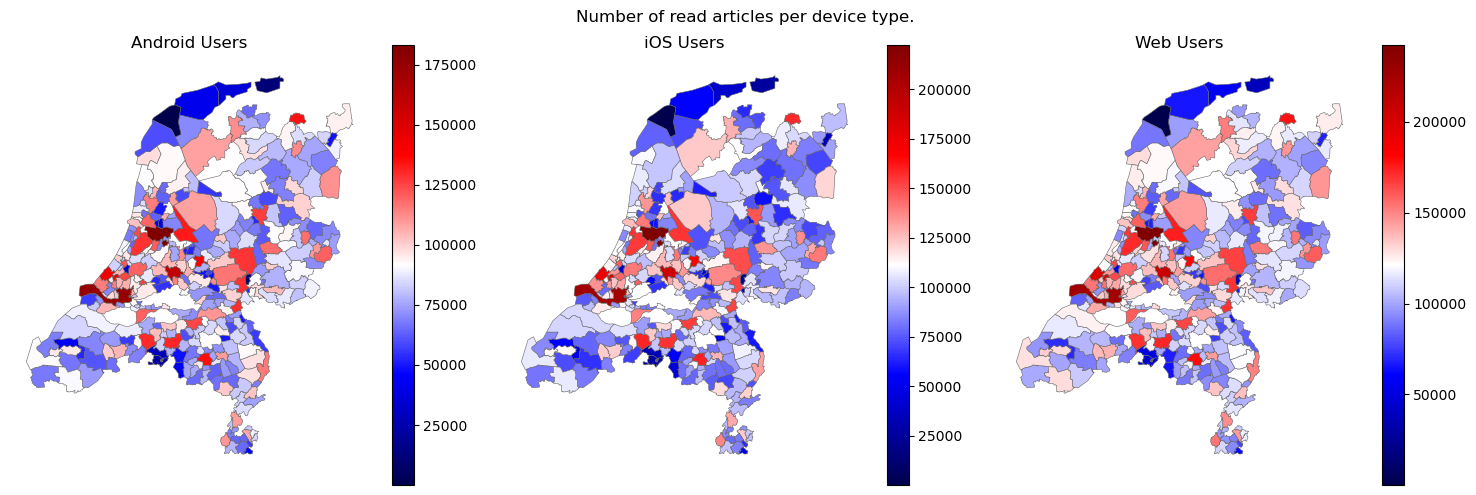

In [148]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

bar_info = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.android"]["ARTICLE_ID"].min(), vmax=gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.android"]["ARTICLE_ID"].max()))
bar_info._A = []
cbar = fig.colorbar(bar_info, ax=axes[0])
gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.android"].plot(column="counts_logged", cmap="seismic", linewidth=0.4, ax=axes[0], edgecolor=".4")

bar_info = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.ios"]["ARTICLE_ID"].min(), vmax=gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.ios"]["ARTICLE_ID"].max()))
bar_info._A = []
cbar = fig.colorbar(bar_info, ax=axes[1])
gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.ios"].plot(column="counts_logged", cmap="seismic", linewidth=0.4, ax=axes[1], edgecolor=".4")

bar_info = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.web"]["ARTICLE_ID"].min(), vmax=gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.web"]["ARTICLE_ID"].max()))
bar_info._A = []
cbar = fig.colorbar(bar_info, ax=axes[2])
gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.web"].plot(column="counts_logged", cmap="seismic", linewidth=0.4, ax=axes[2], edgecolor=".4")

for ax in axes:
    ax.set_axis_off()
axes[0].set_title("Android Users")    
axes[1].set_title("iOS Users")    
axes[2].set_title("Web Users")    
fig.suptitle("Number of read articles per device type.")    
fig.tight_layout()

In [149]:
ddf_location_reduced = ddf_location_full.groupby(['county_code', 'APP_ID']).mean().compute()
ddf_location_reduced

GEO_CITY  article_topic_entropy   num_words  \
county_code APP_ID                                                       
14.0        nu.android   150.652357               2.121046  306.722110   
            nu.ios       141.713902               2.133163  298.856269   
            nu.web       148.044848               2.172007  294.457402   
34.0        nu.android   149.237633               2.104329  306.909965   
            nu.ios       152.363655               2.125718  304.087956   
...                             ...                    ...         ...   
1978.0      nu.web      1388.492333               2.179683  294.619561   
1979.0      nu.android   745.817455               2.151449  321.363757   
            nu.ios       794.306752               2.140583  312.115896   
            nu.web       926.018338               2.171219  299.236527   
96.0        nu.ios       723.000000               2.114574  315.791667   

                        num_sentences  userneed_hou_me_op_de_hoogte  \
county_code APP_ID                                                    
14.0        nu.android      22.049702                      0.418684   
            nu.ios          21.455713                      0.402778   
            nu.web          21.210332                      0.408251   
34.0        nu.android      22.110318                      0.425298   
            nu.ios          21.916818                      0.415206   
...                               ...                           ...   
1978.0      nu.web          21.238293                      0.429584   
1979.0      nu.android      22.996669                      0.412803   
            nu.ios          22.475279                      0.395215   
            nu.web          21.593189                      0.403312   
96.0        nu.ios          22.597222                      0.340263   

                        userneed_geef_me_context  userneed_vermaak_me  \
county_code APP_ID                                                      
14.0        nu.android                  0.330177             0.129267   
            nu.ios                      0.316542             0.146985   
            nu.web                      0.328284             0.141932   
34.0        nu.android                  0.324486             0.127638   
            nu.ios                      0.313796             0.139733   
...                                          ...                  ...   
1978.0      nu.web                      0.329696             0.128857   
1979.0      nu.android                  0.342061             0.119306   
            nu.ios                      0.336291             0.134439   
            nu.web                      0.349860             0.124602   
96.0        nu.ios                      0.401494             0.139658   

                        userneed_raak_me_verbind_me  userneed_help_me  \
county_code APP_ID                                                      
14.0        nu.android                     0.083897          0.037975   
            nu.ios                         0.093841          0.039854   
            nu.web                         0.079555          0.041979   
34.0        nu.android                     0.079534          0.043044   
            nu.ios                         0.087285          0.043980   
...                                             ...               ...   
1978.0      nu.web                         0.070239          0.041624   
1979.0      nu.android                     0.080114          0.045716   
            nu.ios                         0.086451          0.047603   
            nu.web                         0.075631          0.046595   
96.0        nu.ios                         0.085856          0.032728   

                        sensitive_topic_adult  ...  sensitive_topic_drugs  \
county_code APP_ID                             ...                          
14.0        nu.android               0.015617  ...               0.026799   
         

In [150]:
gdf_location = gdf.merge(ddf_location_reduced.reset_index(), left_on="county_code", right_on="county_code", how="left")
gdf_location

code         name           regioFacet  level  \
0     1680  Aa en Hunze  tcm:106-353398-1024      4   
1     1680  Aa en Hunze  tcm:106-353398-1024      4   
2     1680  Aa en Hunze  tcm:106-353398-1024      4   
3     0106        Assen  tcm:106-353399-1024      4   
4     0106        Assen  tcm:106-353399-1024      4   
...    ...          ...                  ...    ...   
1061  1892     Zuidplas  tcm:106-353815-1024      4   
1062  1892     Zuidplas  tcm:106-353815-1024      4   
1063  0642  Zwijndrecht  tcm:106-353816-1024      4   
1064  0642  Zwijndrecht  tcm:106-353816-1024      4   
1065  0642  Zwijndrecht  tcm:106-353816-1024      4   

                                         url  \
0     /regioinformatie/gemeente/aa-en-hunze/   
1     /regioinformatie/gemeente/aa-en-hunze/   
2     /regioinformatie/gemeente/aa-en-hunze/   
3           /regioinformatie/gemeente/assen/   
4           /regioinformatie/gemeente/assen/   
...                                      ...   
1061     /regioinformatie/gemeente/zuidplas/   
1062     /regioinformatie/gemeente/zuidplas/   
1063  /regioinformatie/gemeente/zwijndrecht/   
1064  /regioinformatie/gemeente/zwijndrecht/   
1065  /regioinformatie/gemeente/zwijndrecht/   

                                               geometry  county_code  \
0     MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680   
1     MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680   
2     MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680   
3     MULTIPOLYGON (((6.51304 53.01056, 6.50998 53.0...          106   
4     MULTIPOLYGON (((6.51304 53.01056, 6.50998 53.0...          106   
...                                                 ...          ...   
1061  MULTIPOLYGON (((4.59877 51.98797, 4.59437 51.9...         1892   
1062  MULTIPOLYGON (((4.59877 51.98797, 4.59437 51.9...         1892   
1063  MULTIPOLYGON (((4.56674 51.81283, 4.56118 51.8...          642   
1064  MULTIPOLYGON (((4.56674 51.81283, 4.56118 51.8...          642   
1065  MULTIPOLYGON (((4.56674 51.81283, 4.56118 51.8...          642   

          APP_ID     GEO_CITY  article_topic_entropy  ...  \
0     nu.android  1851.710916               2.110566  ...   
1         nu.ios  1858.025712               2.132681  ...   
2         nu.web  1826.689065               2.185074  ...   
3     nu.android    18.013558               2.113458  ...   
4         nu.ios    71.800223               2.128461  ...   
...          ...          ...                    ...  ...   
1061      nu.ios   241.344546               2.134677  ...   
1062      nu.web   265.081340               2.177149  ...   
1063  nu.android   664.405577               2.125644  ...   
1064      nu.ios   651.792721               2.131231  ...   
1065      nu.web   651.190255               2.172682  ...   

      sensitive_topic_drugs  sensitive_topic_hate_speech  \
0                  0.029230                     0.011555   
1                  0.031194                     0.011418   
2                  0.029705                     0.011470   
3                  0.027153                     0.010970   
4                  0.026600                     0.011703   
...                     ...                          ...   
1061               0.027676                     0.011715   
1062               0.034218                     0.009220   
1063               0.028674                     0.010022   
1064               0.027081                     0.010129   
1065               0.033566                     0.010558   

      sensitive_topic_obscenity  sensitive_topic_piracy  \
0                      0.037901                0.010066   
1                      0.038970                0.013054   
2                      0.033883                0.017965   
3                      0.036577                0.011967   
4                      0.035426                0.011446   
...                         ...                     ...   
1061                   0.035561     

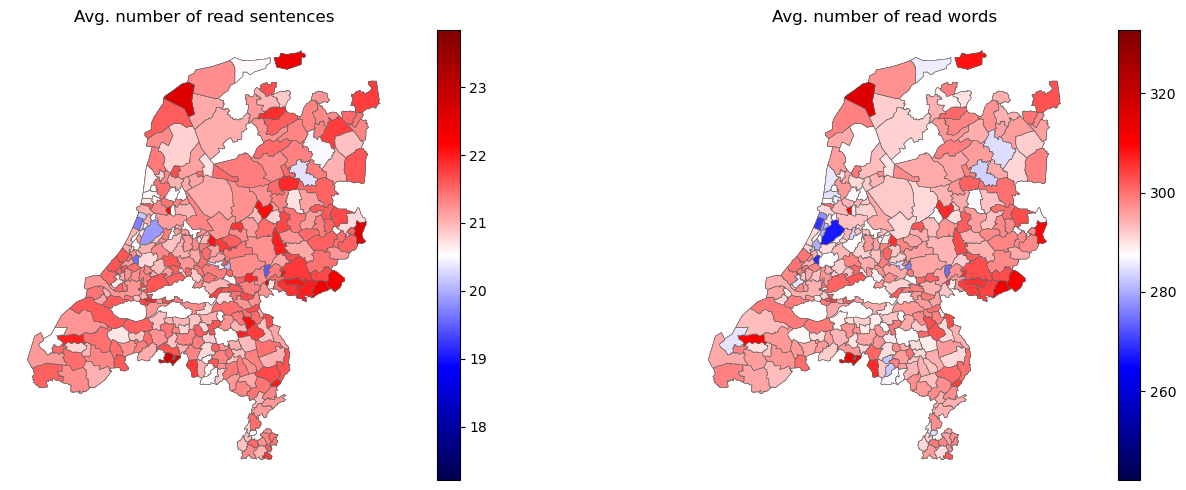

In [156]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

column="num_sentences"
bar_info = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=gdf_location[column].min(), vmax=gdf_location[column].max()))
bar_info._A = []
cbar = fig.colorbar(bar_info, ax=axes[0])
gdf_location.plot(column=column, cmap="seismic", linewidth=0.4, ax=axes[0], edgecolor=".4")

column="num_words"
bar_info = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=gdf_location[column].min(), vmax=gdf_location[column].max()))
bar_info._A = []
cbar = fig.colorbar(bar_info, ax=axes[1])
gdf_location.plot(column=column, cmap="seismic", linewidth=0.4, ax=axes[1], edgecolor=".4")

for ax in axes:
    ax.set_axis_off()
axes[0].set_title("Avg. number of read sentences")    
axes[1].set_title("Avg. number of read words")  

fig.tight_layout()
plt.show()

/tmp/ipykernel_241490/3077191496.py:5: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(bar_info)


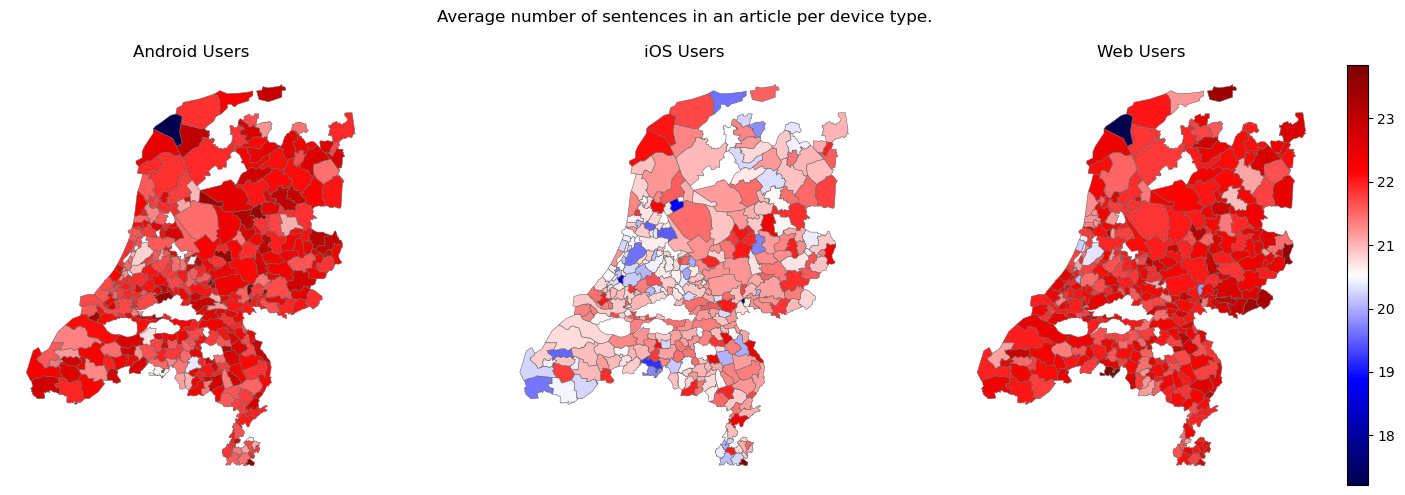

In [157]:
column="num_sentences"
fig, axes = plt.subplots(1,3, figsize=(15,5))
bar_info = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=gdf_location[column].min(), vmax=gdf_location[column].max()))
bar_info._A = []
cbar = fig.colorbar(bar_info)
gdf_location[gdf_location["APP_ID"] == "nu.android"].plot(column=column, cmap="seismic", linewidth=0.4, ax=axes[0], edgecolor=".4")
gdf_location[gdf_location["APP_ID"] == "nu.ios"].plot(column=column, cmap="seismic", linewidth=0.4, ax=axes[1], edgecolor=".4")
gdf_location[gdf_location["APP_ID"] == "nu.web"].plot(column=column, cmap="seismic", linewidth=0.4, ax=axes[2], edgecolor=".4")
for ax in axes:
    ax.set_axis_off()
axes[0].set_title("Android Users")    
axes[1].set_title("iOS Users")    
axes[2].set_title("Web Users")    
fig.suptitle("Average number of sentences in an article per device type.")    
fig.tight_layout()

/tmp/ipykernel_241490/2764776757.py:5: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(bar_info)


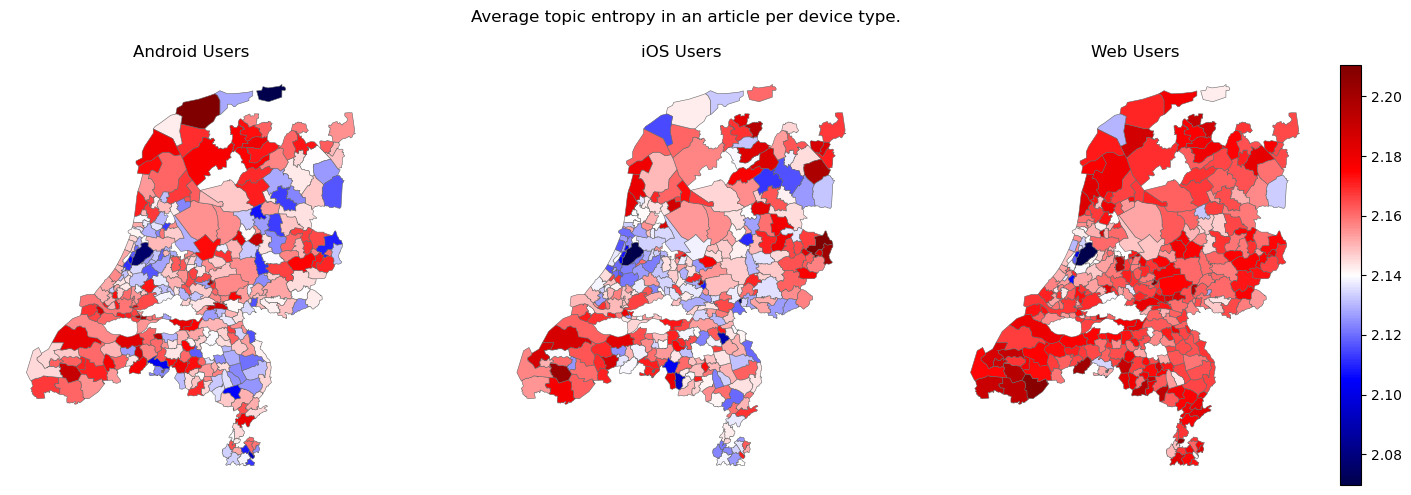

In [158]:
column="article_topic_entropy"
fig, axes = plt.subplots(1,3, figsize=(15,5))
bar_info = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=gdf_location[column].min(), vmax=gdf_location[column].max()))
bar_info._A = []
cbar = fig.colorbar(bar_info)
gdf_location[gdf_location["APP_ID"] == "nu.android"].plot(column=column, cmap="seismic", linewidth=0.4, ax=axes[0], edgecolor=".4")
gdf_location[gdf_location["APP_ID"] == "nu.ios"].plot(column=column, cmap="seismic", linewidth=0.4, ax=axes[1], edgecolor=".4")
gdf_location[gdf_location["APP_ID"] == "nu.web"].plot(column=column, cmap="seismic", linewidth=0.4, ax=axes[2], edgecolor=".4")
for ax in axes:
    ax.set_axis_off()
axes[0].set_title("Android Users")    
axes[1].set_title("iOS Users")    
axes[2].set_title("Web Users")    
fig.suptitle("Average topic entropy in an article per device type.")    
fig.tight_layout()

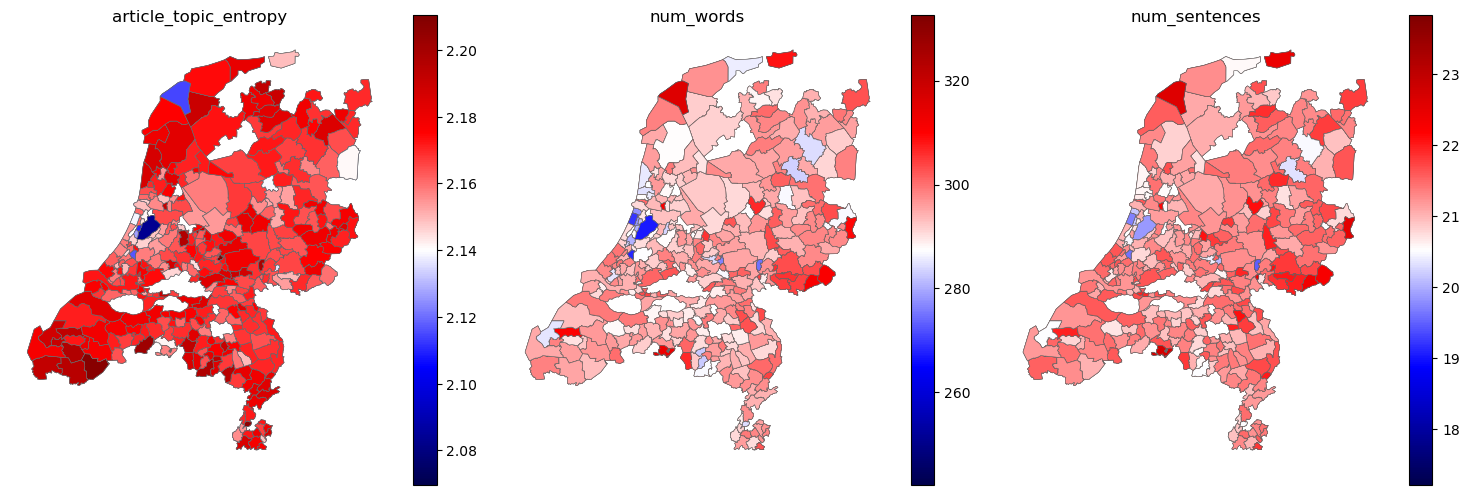

In [159]:
column1="article_topic_entropy"
column2="num_words"
column3="num_sentences"
fig, axes = plt.subplots(1,3, figsize=(15,5))
tmp_cols = [column1,column2,column3]
faxes = axes
for col, ax in zip(tmp_cols, faxes):
    bar_info1 = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=gdf_location[col].min(), vmax=gdf_location[col].max()))
    bar_info1._A = []
    cbar1 = fig.colorbar(bar_info1, ax=ax)
    gdf_location.plot(column=col, cmap="seismic", linewidth=0.4, ax=ax, edgecolor=".4")
    # ax.set_xlim(0,1)
    ax.set_axis_off()
    ax.set_title(f"{col}")
faxes[-1].set_axis_off()        
fig.tight_layout()
plt.show()

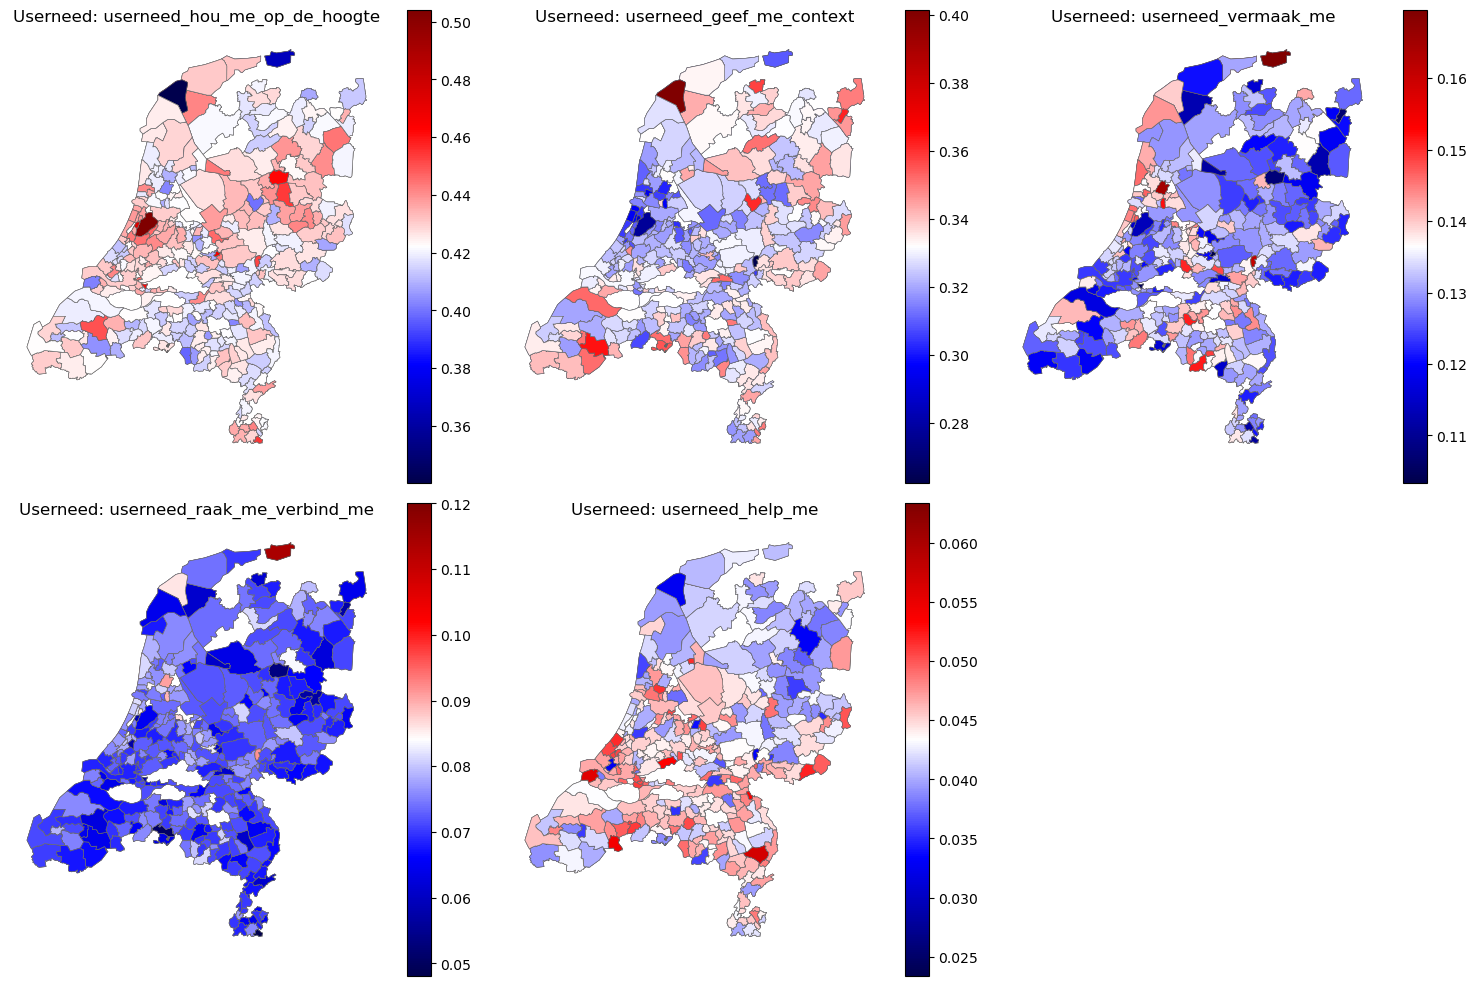

In [160]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
faxes = axes.flatten()

for need, ax in zip(columns_userneeds, faxes):
    bar_info1 = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=gdf_location[need].min().min(), vmax=gdf_location[need].max().max()))
    bar_info1._A = []
    cbar1 = fig.colorbar(bar_info1, ax=ax)
    gdf_location.plot(column=need, cmap="seismic", linewidth=0.4, ax=ax, edgecolor=".4")
    # ax.set_xlim(0,1)
    ax.set_axis_off()
    ax.set_title(f"Userneed: {need}")
faxes[-1].set_axis_off()        
fig.tight_layout()
plt.show()


 92%|█████████▏| 12/13 [00:12<00:01,  1.03s/it]


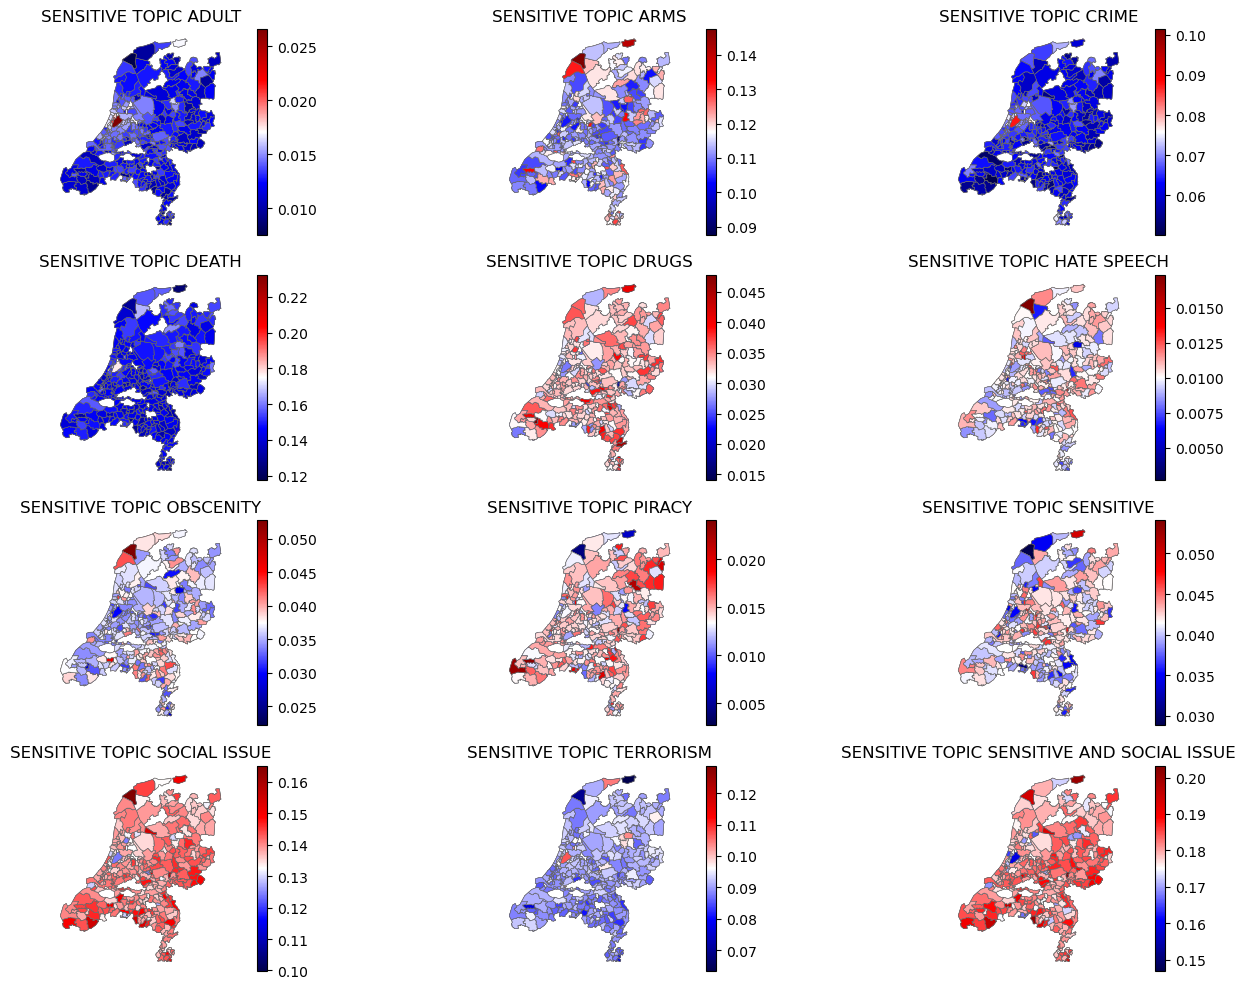

In [161]:
fig, axes = plt.subplots(4,3, figsize=(15,10))
faxes = axes.flatten()

for sensitivity, ax in tqdm.tqdm(zip(columns_sensitivity, faxes), total=len(columns_sensitivity)):
    bar_info1 = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=gdf_location[sensitivity].min().min(), vmax=gdf_location[sensitivity].max().max()))
    bar_info1._A = []
    cbar1 = fig.colorbar(bar_info1, ax=ax)
    gdf_location.plot(column=sensitivity, cmap="seismic", linewidth=0.4, ax=ax, edgecolor=".4")
    # ax.set_xlim(0,1)
    ax.set_axis_off()
    ax.set_title(f"{' '.join(sensitivity.upper().split('_'))}")
faxes[-1].set_axis_off()        
fig.tight_layout()
plt.show()

# Time and Date Correlations

In [ ]:
# ddf_sensitivity = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_sensitive.csv')
# columns_sensitivity = list(ddf_sensitivity.columns[ddf_sensitivity.columns.str.startswith("sensitive_")].values)
# ddf_sensitivity = ddf_sensitivity.assign(argmax_sensitivity = ddf_sensitivity[columns_sensitivity].idxmax(axis=1))
# ddf_sensitivity = ddf_sensitivity.assign(is_sensitive = ddf_sensitivity[columns_sensitivity].sum(axis=1))
# ddf_sensitivity = ddf_sensitivity.dropna(subset="sensitive_topic_terrorism")
# ddf_sensitivity = ddf_sensitivity.assign(article_sensitivity_entropy = ddf_sensitivity[columns_sensitivity].apply(lambda x: entropy(x) if x.sum()!=0 else 0, axis=1, meta='float64'))
# ddf_sensitivity = ddf_sensitivity.set_index('article_id').persist()
# ddf_sensitivity.head()

# columns_dt = list(ddf_views.columns[ddf_views.columns.str.startswith("dt_")].values)


In [162]:
columns_dt = list(ddf_views.columns[ddf_views.columns.str.startswith("dt_")].values)
ddf_time = ddf_views[["APP_ID", *columns_dt]]
# ddf_time = ddf_time.merge(ddf_topics[topic_columns])
ddf_time = ddf_time.merge(ddf_userneeds[columns_userneeds])
ddf_time = ddf_time.merge(ddf_sensitivity)
# ddf_time = ddf_time.persist()
ddf_time.head(20)

In [ ]:
ddf_time_hour = ddf_time.groupby('dt_hour').mean().compute()
ddf_time_weekday = ddf_time.groupby('dt_weekday').mean().compute()
ddf_time_month = ddf_time.groupby('dt_month').mean().compute()

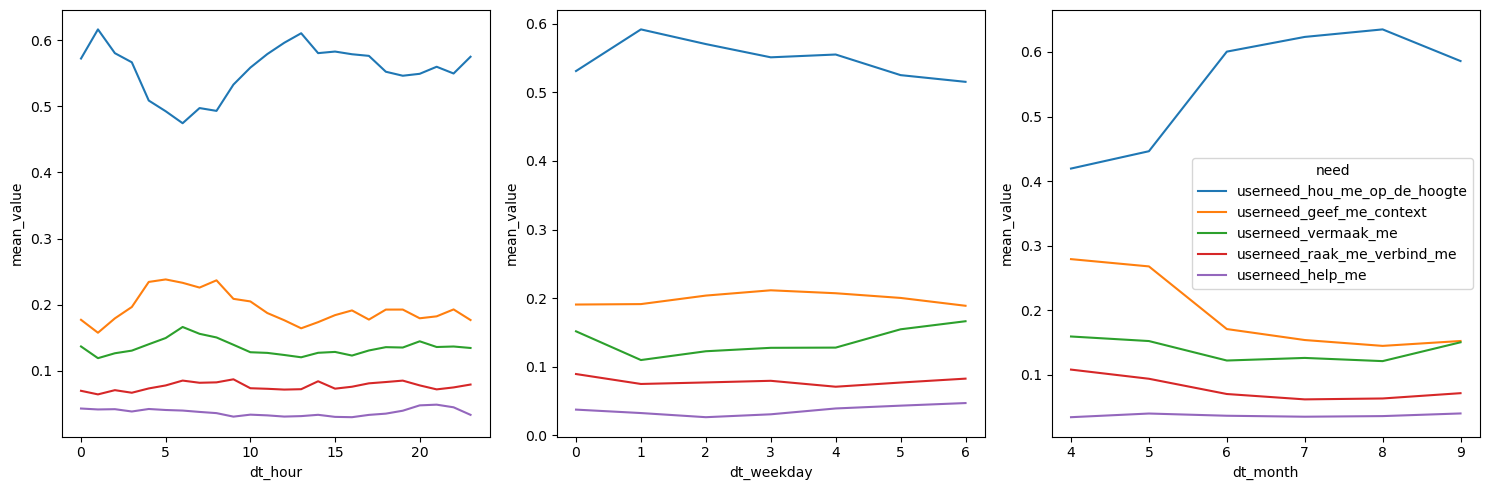

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,5), squeeze=False)
faxes = axes.flatten()
lasti = len(faxes)
for idx,(df_dt_tmp, ax) in enumerate(zip([ddf_time_hour, ddf_time_weekday, ddf_time_month], faxes)):
    # TODO: For consistency turn topic_columns to columns_topics
    tmp = df_dt_tmp.melt(value_vars=columns_userneeds, var_name="need", value_name="mean_value", ignore_index=False)
    col = tmp.index.name
    tmp = tmp.reset_index()
    sns.lineplot(data=tmp, x=col, y="mean_value", hue="need", ax=ax, legend=idx==lasti-1)
# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, loc = (0.5, 0), ncol=5)
fig.tight_layout()
plt.show()

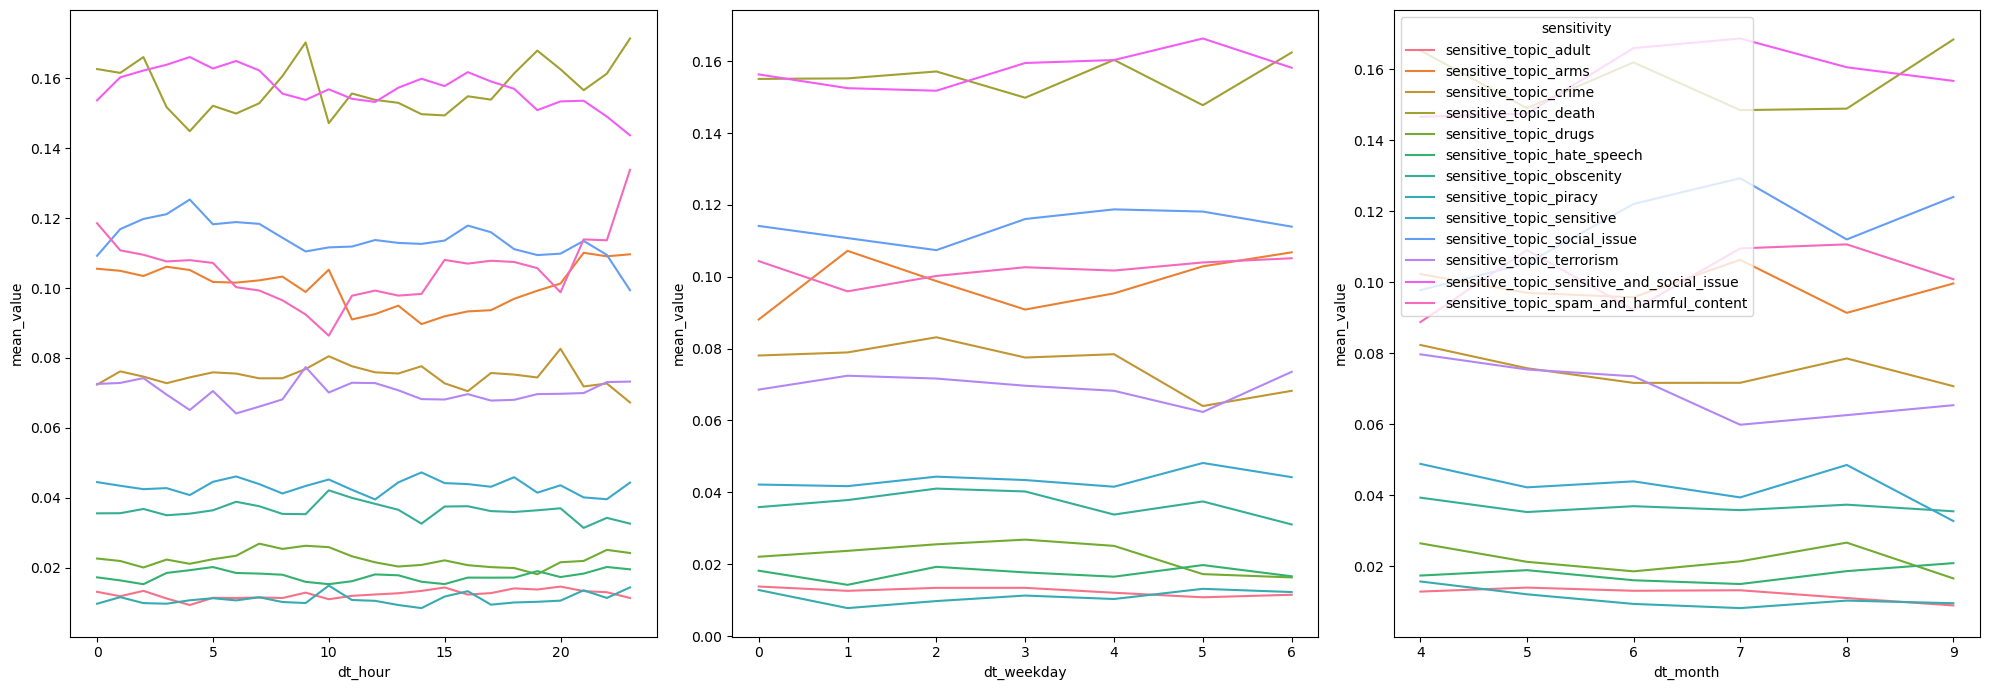

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,7), squeeze=False)
faxes = axes.flatten()
lasti = len(faxes)
for idx,(df_dt_tmp, ax) in enumerate(zip([ddf_time_hour, ddf_time_weekday, ddf_time_month], faxes)):
    # TODO: For consistency turn topic_columns to columns_topics
    tmp = df_dt_tmp.melt(value_vars=columns_sensitivity, var_name="sensitivity", value_name="mean_value", ignore_index=False)
    col = tmp.index.name
    tmp = tmp.reset_index()
    sns.lineplot(data=tmp, x=col, y="mean_value", hue="sensitivity", ax=ax, legend=idx==lasti-1)
# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, loc = (0.5, 0), ncol=5)
fig.tight_layout()
plt.show()

# INTERACTION

In [ ]:
DATA_FOLDER = "reduced"
ddf_interactions = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER}/reduced_interactions.csv')
tmp = ddf_interactions[["ARTICLE_ID","SE_LABEL", "SE_ACTION"]].compute()
unique_interactions_1 = tmp["SE_LABEL"].unique()
unique_interactions_2 = tmp["SE_ACTION"].unique()
ddf_interactions["article_id"] = ddf_interactions["ARTICLE_ID"]
ddf_interactions = ddf_interactions.set_index('article_id')
ddf_interactions.head()

APP_ID  ARTICLE_ID            DERIVED_TSTAMP SE_ACTION  \
article_id                                                           
2108938     nu.web     2108938  2022-04-01T06:59:06.270Z  whatsapp   
2822099     nu.web     2822099  2022-04-01T16:41:30.059Z  whatsapp   
3728111     nu.web     3728111  2022-04-01T15:27:13.639Z  whatsapp   
3773082     nu.web     3773082  2022-04-01T14:33:33.622Z  facebook   
4238965     nu.web     4238965  2022-04-01T18:23:47.249Z   twitter   

                          SE_CATEGORY SE_LABEL  SE_VALUE  \
article_id                                                 
2108938     article-social-share-icon      top       1.0   
2822099     article-social-share-icon   bottom       1.0   
3728111     article-social-share-icon   bottom       1.0   
3773082     article-social-share-icon      top       1.0   
4238965     article-social-share-icon   bottom       1.0   

                               QUASI_USER_ID  IS_LOGGED_IN  GEO_CITY  ...  \
article_id                                                            ...   
2108938     9d8c297ed0b5189753565b17c0242ad9             1       137  ...   
2822099     1143e2124ee3b44d2b5b034fa84a2b36             1       125  ...   
3728111     d70d49207ff0115cc0179c98afa2e689             1         7  ...   
3773082     5f3017b2811a3d436f63984b5e1d774c             1       324  ...   
4238965     36ff5e0e1257a9806fb85f9dc2bff8a4             1        24  ...   

            privacy_non-personalised_ads  privacy_marketing  \
article_id                                                    
2108938                                1                  1   
2822099                                1                  1   
3728111                                1                  1   
3773082                                1                  1   
4238965                                1                  1   

            privacy_social_media  privacy_geo_location  privacy_advertising  \
article_id                                                                    
2108938                        1                     0                    1   
2822099                        1                     0                    1   
3728111                        1                     0                    1   
3773082                        1                     0                    1   
4238965                        1                     0                    1   

            file_name  GEO_COUNTRY  GEO_REGION  GEO_ZIPCODE  REFR_MEDIUM  
article_id                                                                
2108938             0           NL          FL         1318       search  
2822099             0           NL          GE         3772       search  
3728111             0           NL          NH         1025          NaN  
3773082             0           NL          NB         5431       search  
4238965             0           NL         NaN          NaN       social  

[5 rows x 25 columns]

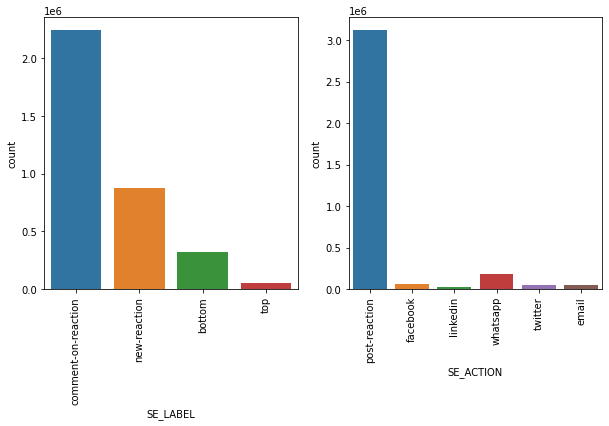

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(data=tmp, x="SE_LABEL", ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 90)
sns.countplot(data=tmp, x="SE_ACTION", ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90)
plt.show()


In [ ]:
ddf_topics_merged_interactions = ddf_topics.merge(ddf_interactions[["ARTICLE_ID", "SE_LABEL", "SE_ACTION"]], how="inner", left_on='article_id', right_on='ARTICLE_ID').persist()
display(ddf_topics_merged_interactions)


/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:7201: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


Empty DataFrame
Columns: [topic_voetbal, topic_optredens_en_voorstellingen, topic_politiek, topic_technologie_en_handel, topic_relatie_en_opvoeden, topic_bestuur_en_organisatie, topic_human_interest, topic_verkeersongevallen, topic_nominatie_en_prijzen, topic_veiligheid, topic_onderwijs, topic_maatschappelijke_instellingen, topic_economie, topic_lokale_evenementen, topic_het_weer, topic_brand, topic_verkeer, topic_gezondheid_en_zorg, topic_gemeentepolitiek, topic_sport, topic_kunst_en_cultuur, topic_eten_en_drinken, topic_natuur, topic_duurzaamheid, topic_misdaad, topic_wielrennen, topic_zingeving_en_verhalen, topic_afval_en_milieuproblematiek, topic_consumeren_en_vrije_tijd, topic_overheidsbeleid, topic_vakbond_club_en_vereniging, topic_religie, topic_bouwen_en_wonen, topic_recht_en_justitie, topic_samenleving, topic_woon_en_leefomgeving, file_name, article_topic_entropy, argmax_topic, APP_ID]
Index: []

[0 rows x 40 columns]

4it [00:03,  1.15it/s]


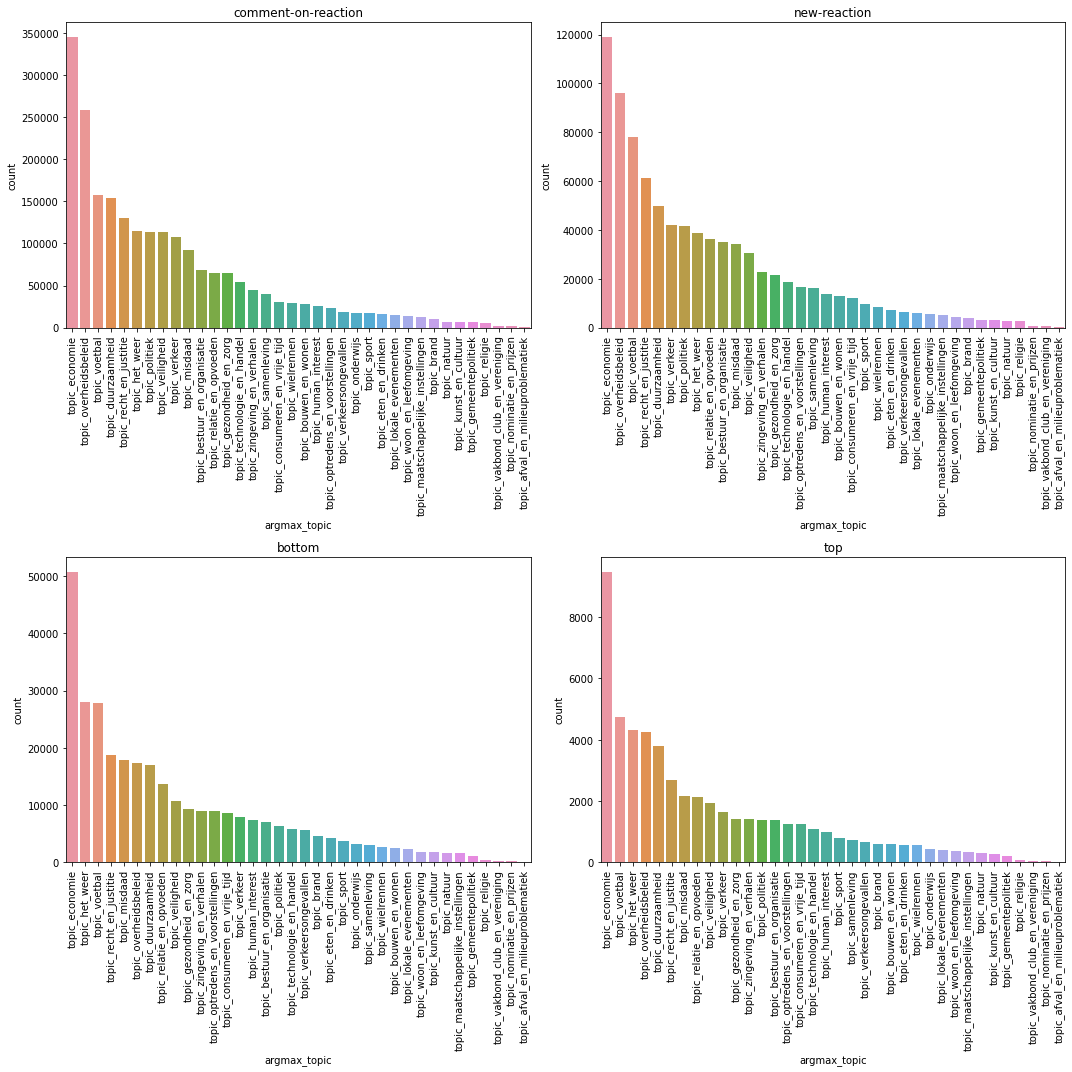

In [ ]:
fig, axes = plt.subplots(2,(len(unique_interactions_1)//2), figsize=(15, 15))
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[["argmax_topic", "SE_LABEL"]].compute()
for interaction, ax in tqdm.tqdm(zip(unique_interactions_1, faxes)):
    order = tmp.loc[tmp["SE_LABEL"]==interaction]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["SE_LABEL"]==interaction], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(interaction)
fig.tight_layout()
plt.show()

6it [00:04,  1.36it/s]


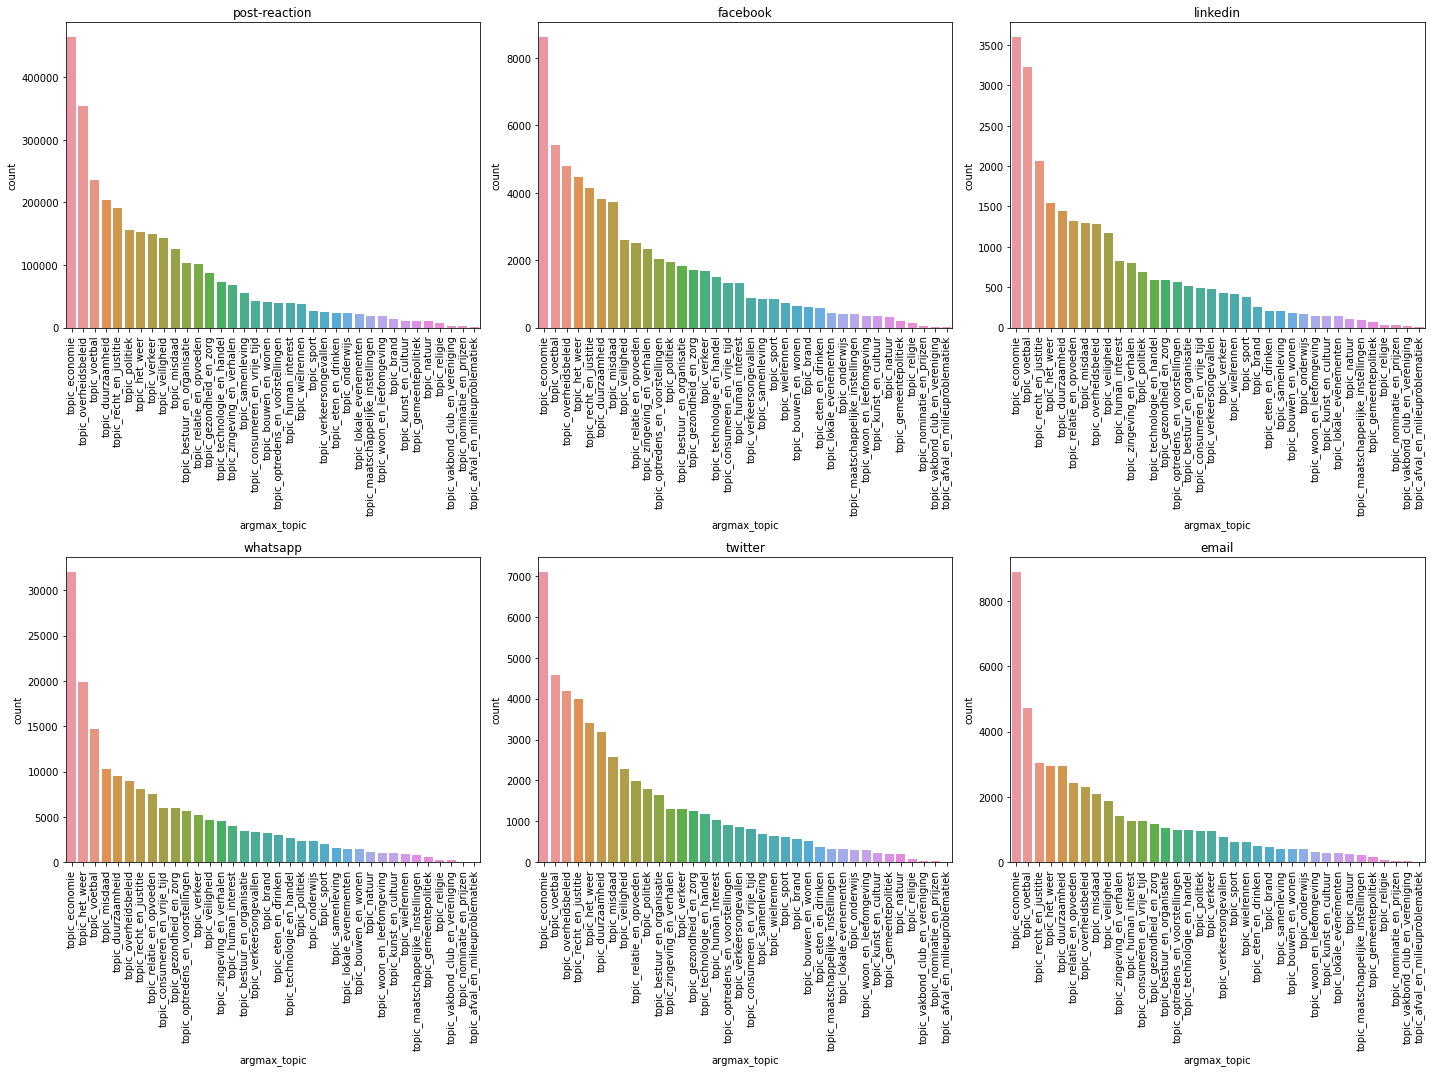

In [ ]:
fig, axes = plt.subplots(2,(len(unique_interactions_2)//2), figsize=(20, 15))
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[["argmax_topic", "SE_ACTION"]].compute()
for interaction, ax in tqdm.tqdm(zip(unique_interactions_2, faxes)):
    order = tmp.loc[tmp["SE_ACTION"]==interaction]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["SE_ACTION"]==interaction], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(interaction)
fig.tight_layout()
plt.show()

In [ ]:
l_test_results = list()
tmp = ddf_topics_merged_interactions.sample(frac=0.01).compute()
for topic in tqdm.tqdm(topic_columns):
    res = {"topic": topic, **pg.kruskal(data=tmp, dv=topic, between="SE_LABEL").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 36/36 [00:00<00:00, 65.75it/s]


topic    Source  ddof1           H  \
29                topic_overheidsbeleid  SE_LABEL      3  240.657766   
6                  topic_human_interest  SE_LABEL      3  147.339482   
7              topic_verkeersongevallen  SE_LABEL      3  110.376908   
17             topic_gezondheid_en_zorg  SE_LABEL      3  107.024381   
20               topic_kunst_en_cultuur  SE_LABEL      3   98.728125   
2                        topic_politiek  SE_LABEL      3   97.597878   
0                         topic_voetbal  SE_LABEL      3   91.248555   
14                       topic_het_weer  SE_LABEL      3   79.432707   
23                   topic_duurzaamheid  SE_LABEL      3   78.678388   
1     topic_optredens_en_voorstellingen  SE_LABEL      3   74.606139   
28       topic_consumeren_en_vrije_tijd  SE_LABEL      3   73.306305   
4             topic_relatie_en_opvoeden  SE_LABEL      3   68.751152   
26          topic_zingeving_en_verhalen  SE_LABEL      3   63.870516   
21                topic_eten_en_drinken  SE_LABEL      3   59.764352   
22                         topic_natuur  SE_LABEL      3   54.917513   
35           topic_woon_en_leefomgeving  SE_LABEL      3   49.397377   
19                          topic_sport  SE_LABEL      3   48.996966   
12                       topic_economie  SE_LABEL      3   45.503046   
13             topic_lokale_evenementen  SE_LABEL      3   39.870525   
9                      topic_veiligheid  SE_LABEL      3   38.894634   
3           topic_technologie_en_handel  SE_LABEL      3   34.306563   
5          topic_bestuur_en_organisatie  SE_LABEL      3   32.693618   
8            topic_nominatie_en_prijzen  SE_LABEL      3   30.867479   
25                     topic_wielrennen  SE_LABEL      3   25.794463   
30     topic_vakbond_club_en_vereniging  SE_LABEL      3   23.239884   
27    topic_afval_en_milieuproblematiek  SE_LABEL      3   22.317877   
24                        topic_misdaad  SE_LABEL      3   21.386553   
33              topic_recht_en_justitie  SE_LABEL      3   20.962447   
32                topic_bouwen_en_wonen  SE_LABEL      3   20.851861   
31                        topic_religie  SE_LABEL      3   18.461673   
10                      topic_onderwijs  SE_LABEL      3   14.205593   
18               topic_gemeentepolitiek  SE_LABEL      3   10.739295   
34                    topic_samenleving  SE_LABEL      3    7.043703   
15                          topic_brand  SE_LABEL      3    6.194175   
16                        topic_verkeer  SE_LABEL      3    3.689078   
11  topic_maatschappelijke_instellingen  SE_LABEL      3    3.220550   

           p-unc  
29  6.859044e-52  
6   9.877699e-32  
7   9.103755e-24  
17  4.793303e-23  
20  2.917121e-21  
2   5.104272e-21  
0   1.181312e-19  
14  4.061761e-17  
23  5.895100e-17  
1   4.400667e-16  
28  8.357119e-16  
4   7.900262e-15  
26  8.748440e-14  
21  6.600694e-13  
22  7.150094e-12  
35  1.073562e-10  
19  1.306398e-10  
12  7.233480e-10  
13  1.135014e-08  
9   1.827201e-08  
3   1.706869e-07  
5   3.737357e-07  
8   9.064520e-07  
25  1.053073e-05  
30  3.599053e-05  
27  5.601377e-05  
24  8.750292e-05  
33  1.071837e-04  
32  1.130031e-04  
31  3.532079e-04  
10  2.638252e-03  
18  1.322246e-02  
34  7.051777e-02  
15  1.025360e-01  
16  2.970545e-01  
11  3.588545e-01

100%|██████████| 36/36 [00:12<00:00,  2.90it/s]


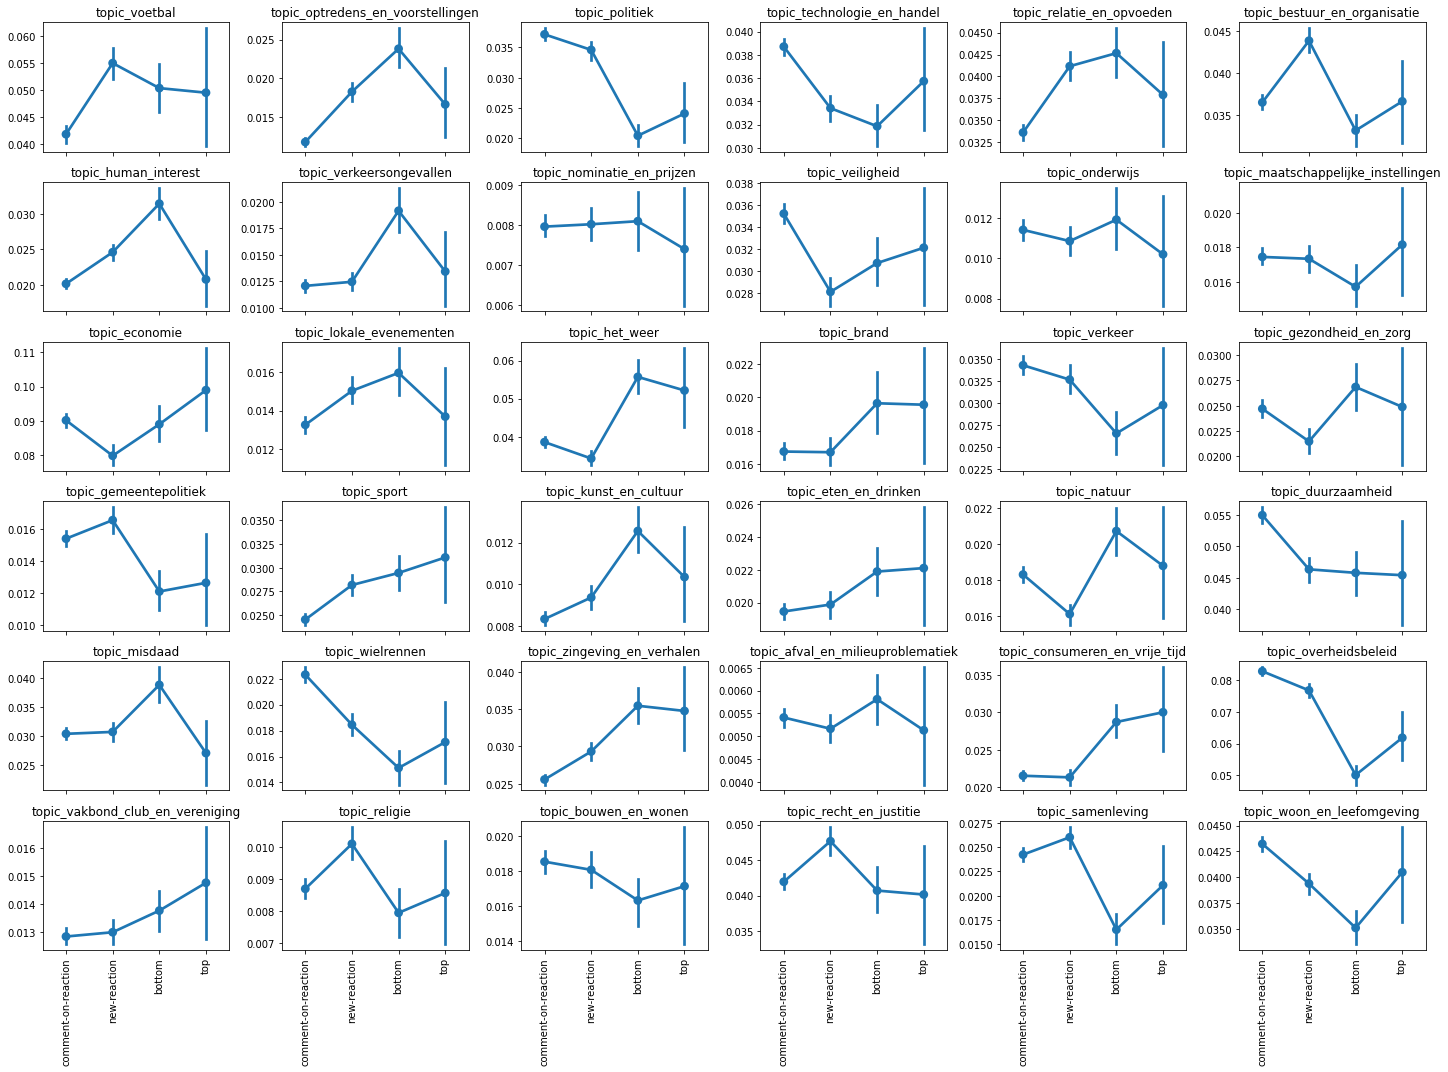

In [ ]:
# TODO: Change the scale so it's not shared between the plots
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions.sample(frac=0.01).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="SE_LABEL", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(topic)
fig.tight_layout()  
plt.show()

100%|██████████| 36/36 [01:44<00:00,  2.89s/it]


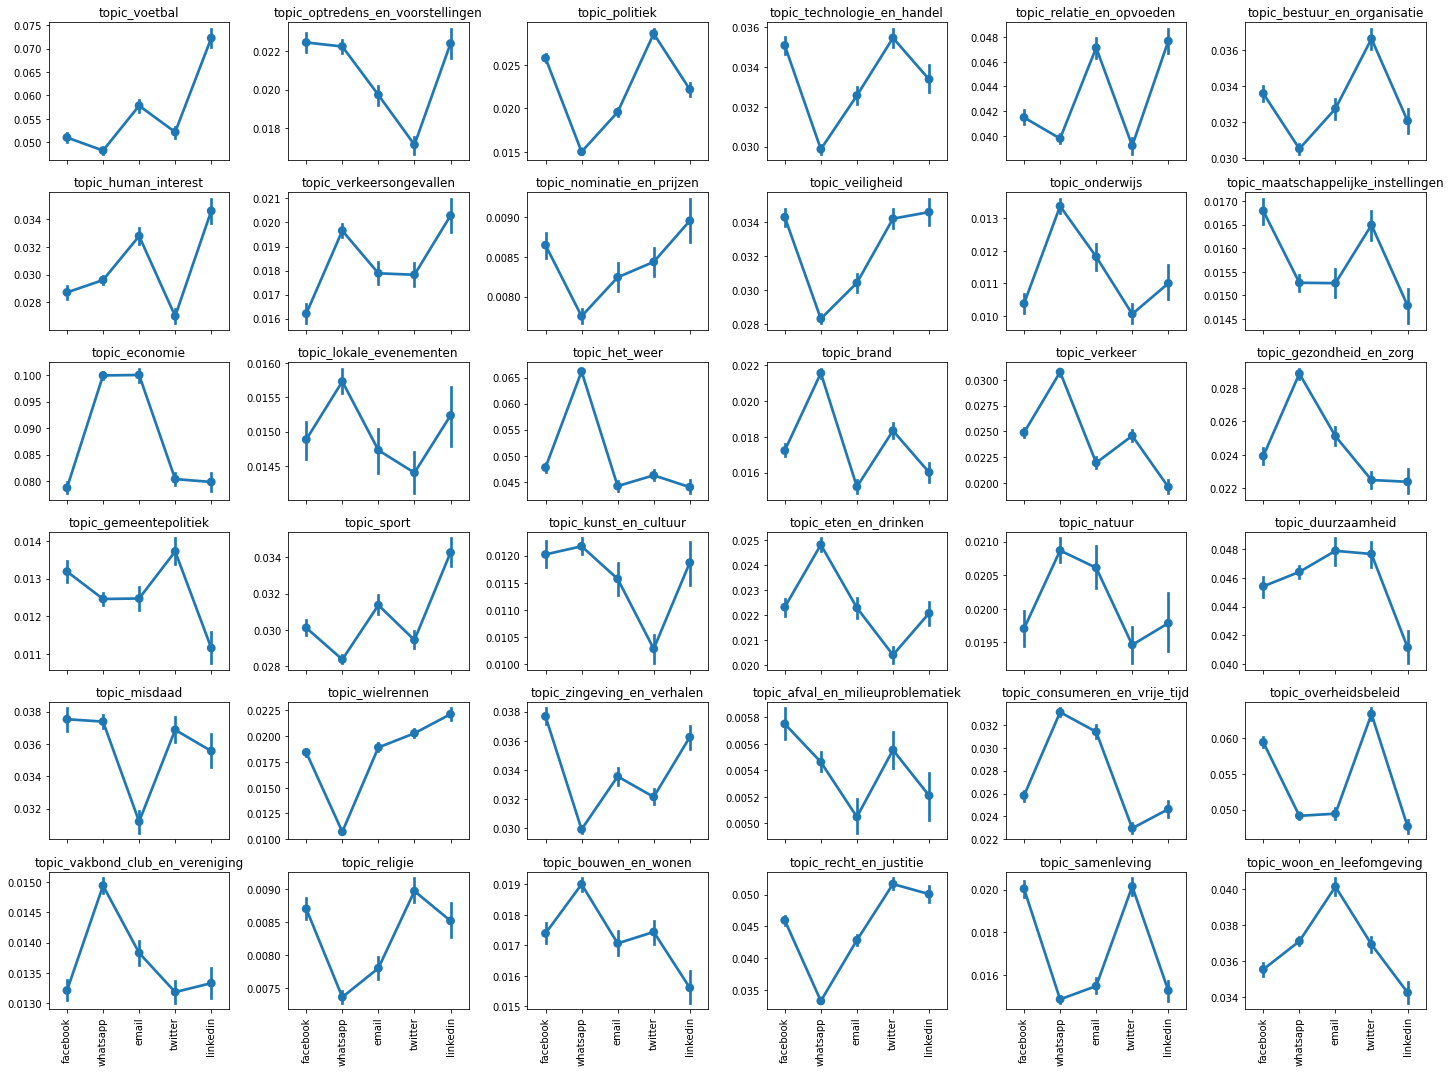

In [ ]:
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[ddf_topics_merged_interactions["SE_ACTION"] != "post-reaction"].sample(frac=1).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="SE_ACTION", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(topic)
fig.tight_layout()  
plt.show()

In [ ]:
ddf_interaction_sensitivity_merge = ddf_interactions.merge(ddf_sensitivity)
ddf_interaction_sensitivity_merge

Dask DataFrame Structure:
               APP_ID ARTICLE_ID DERIVED_TSTAMP SE_ACTION SE_CATEGORY SE_LABEL SE_VALUE QUASI_USER_ID IS_LOGGED_IN GEO_CITY REFR_URLHOST privacy_functional privacy_analytics privacy_target_advertising privacy_personalisation privacy_non-personalised_ads privacy_marketing privacy_social_media privacy_geo_location privacy_advertising file_name GEO_COUNTRY GEO_REGION GEO_ZIPCODE REFR_MEDIUM sensitive_topic_adult sensitive_topic_arms sensitive_topic_crime sensitive_topic_death sensitive_topic_drugs sensitive_topic_hate_speech sensitive_topic_obscenity sensitive_topic_piracy sensitive_topic_sensitive sensitive_topic_social_issue sensitive_topic_terrorism sensitive_topic_sensitive_and_social_issue sensitive_topic_spam_and_harmful_content argmax_sensitivity is_sensitive article_sensitivity_entropy
npartitions=1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
               object      int64         object    object      object   object  float64        object        int64    int64        int64              int64             int64                      int64                   int64                        int64             int64                int64                int64               int64     int64      object     object      object      object               float64              float64               float64               float64               float64                     float64                   float64                float64                   float64                      float64                   float64                                    float64                                  float64             object      float64                     float64
                  ...        ...            ...       ...         ...      ...      ...           ...          ...      ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...         ...        ...         ...         ...                   ...                  ...                   ...                   ...                   ...                         ...                       ...                    ...                       ...                          ...                       ...                                        ...                                      ...                ...          ...                         ...
Dask Name: merge_chunk, 19 graph layers

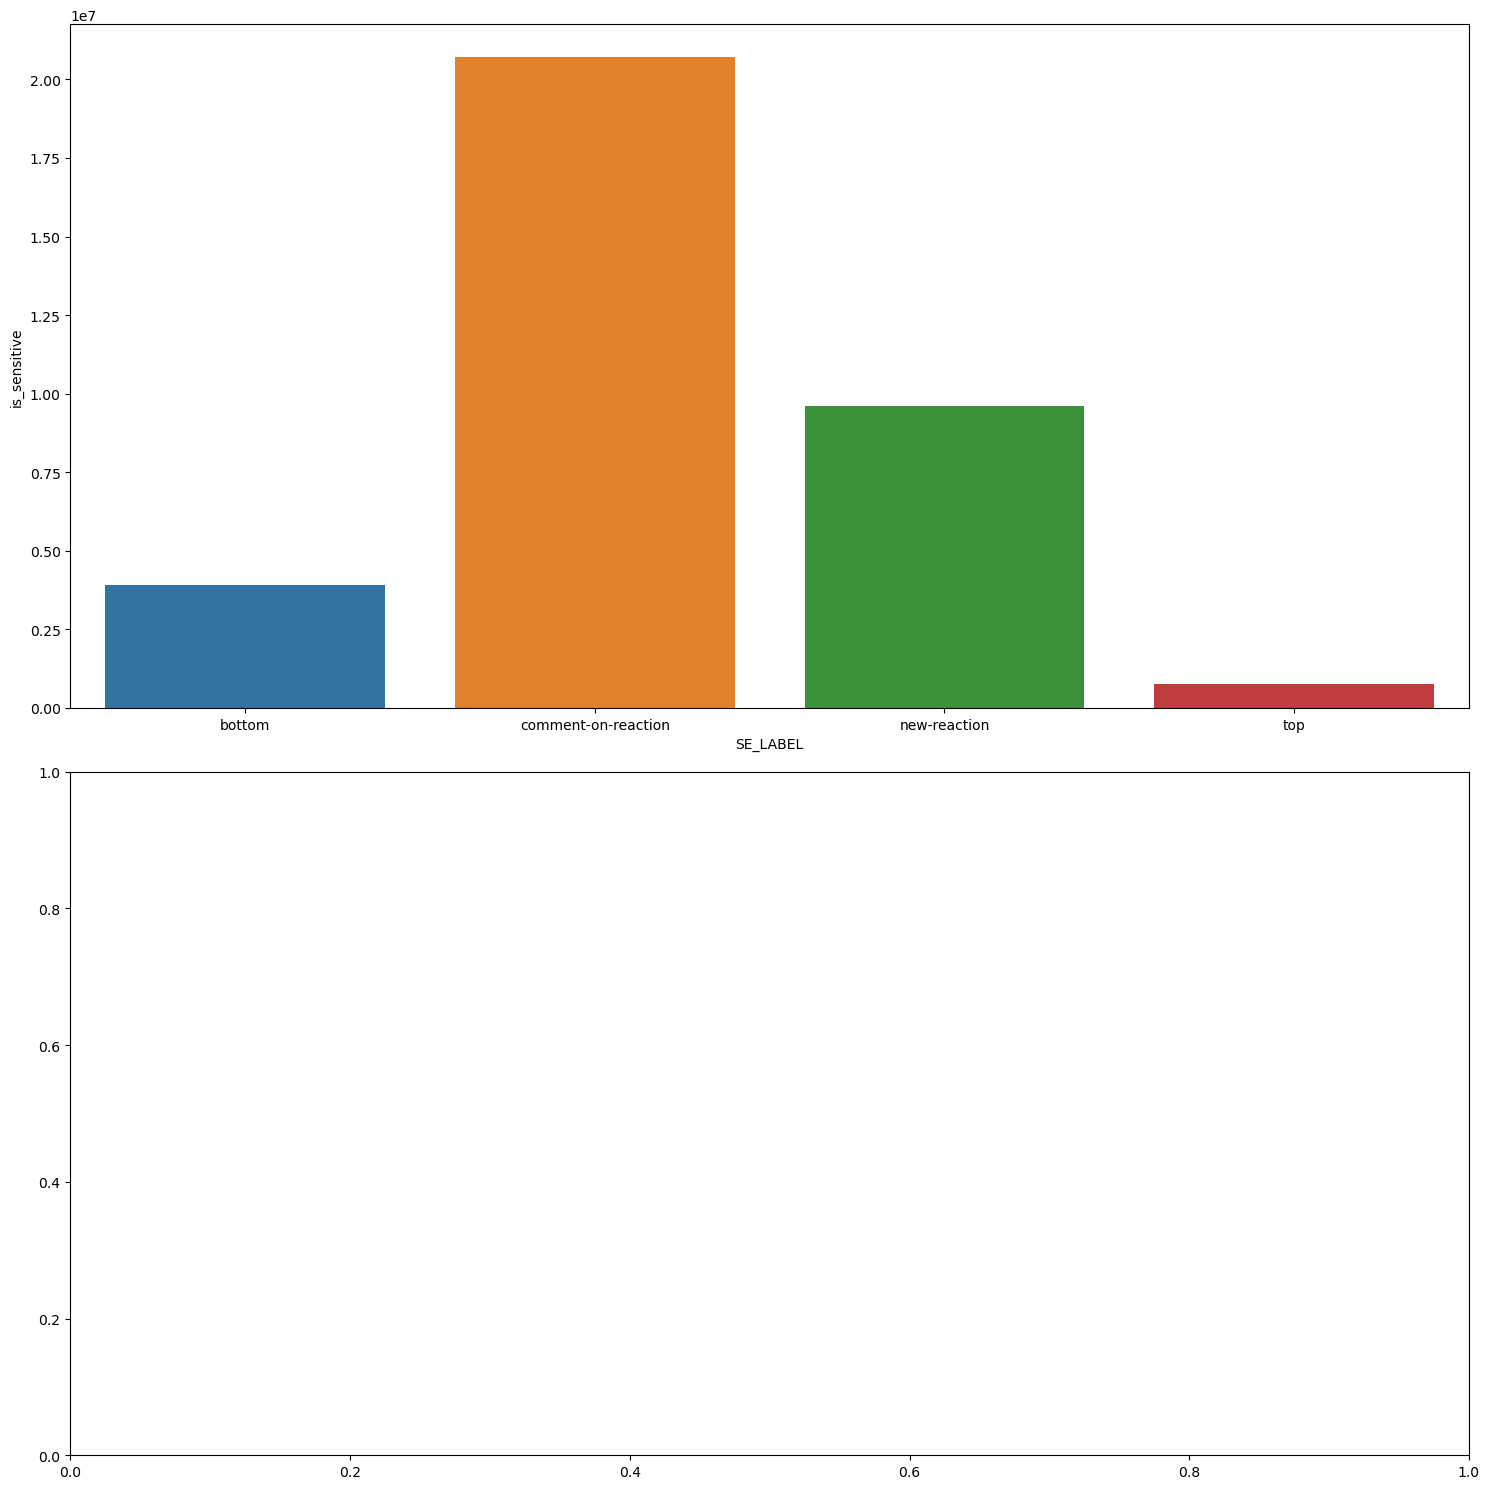

In [ ]:
# fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15, 15))
# tmp = ddf_interaction_sensitivity_merge[["SE_LABEL","is_sensitive"]].groupby("SE_LABEL").sum().compute().reset_index()
# sns.barplot(data=tmp, x="SE_LABEL", y="is_sensitive", ax=ax1)
# fig.tight_layout()
# plt.show()